## General imports

In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.lines import Line2D  
from matplotlib.ticker import ScalarFormatter
import ray
import os
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('font', family='serif')
import logging

# State-of-the-art LDP protocols
from ldp_protocols.ue import UnaryEncoding
from ldp_protocols.lh import LocalHashing
from ldp_protocols.he import HistogramEncoding
from ldp_protocols.ss import SubsetSelection
from ldp_protocols.grr import GeneralizedRandomizedResponse

# Our LDP protocols
from ldp_protocols.ass import AdaptiveSubsetSelection
from ldp_protocols.aue import AdaptiveUnaryEncoding
from ldp_protocols.alh import AdaptiveLocalHashing
from ldp_protocols.athe import AdaptiveThresholdingHistogramEncoding

# Config file
import config_experiments as cfg

## Static parameters

In [2]:
# Baseline protocols
baseline_protocols = [
                    ('GRR', GeneralizedRandomizedResponse), 
                    ('SUE', lambda k, eps: UnaryEncoding(k, eps, optimal=False)),
                    ('BLH', lambda k, eps: LocalHashing(k, eps, optimal=False)),
                    ('SHE', lambda k, eps: HistogramEncoding(k, eps, thresholding=False)),
                    ('SS', SubsetSelection),
                    ('OUE', lambda k, eps: UnaryEncoding(k, eps, optimal=True)),
                    ('OLH', lambda k, eps: LocalHashing(k, eps, optimal=True)),
                    ('THE', lambda k, eps: HistogramEncoding(k, eps, thresholding=True)),
                     ]

# Our Reoptimized LDP protocols
our_protocols = [
                ("ASS", AdaptiveSubsetSelection),
                ("AUE", AdaptiveUnaryEncoding), 
                ("ALH", AdaptiveLocalHashing), 
                ("ATHE", AdaptiveThresholdingHistogramEncoding)           
                ]

# List of protocols
protocols = baseline_protocols + our_protocols

## ASR vs epsilon analysis

2025-01-06 13:18:35,812	INFO worker.py:1749 -- Started a local Ray instance.


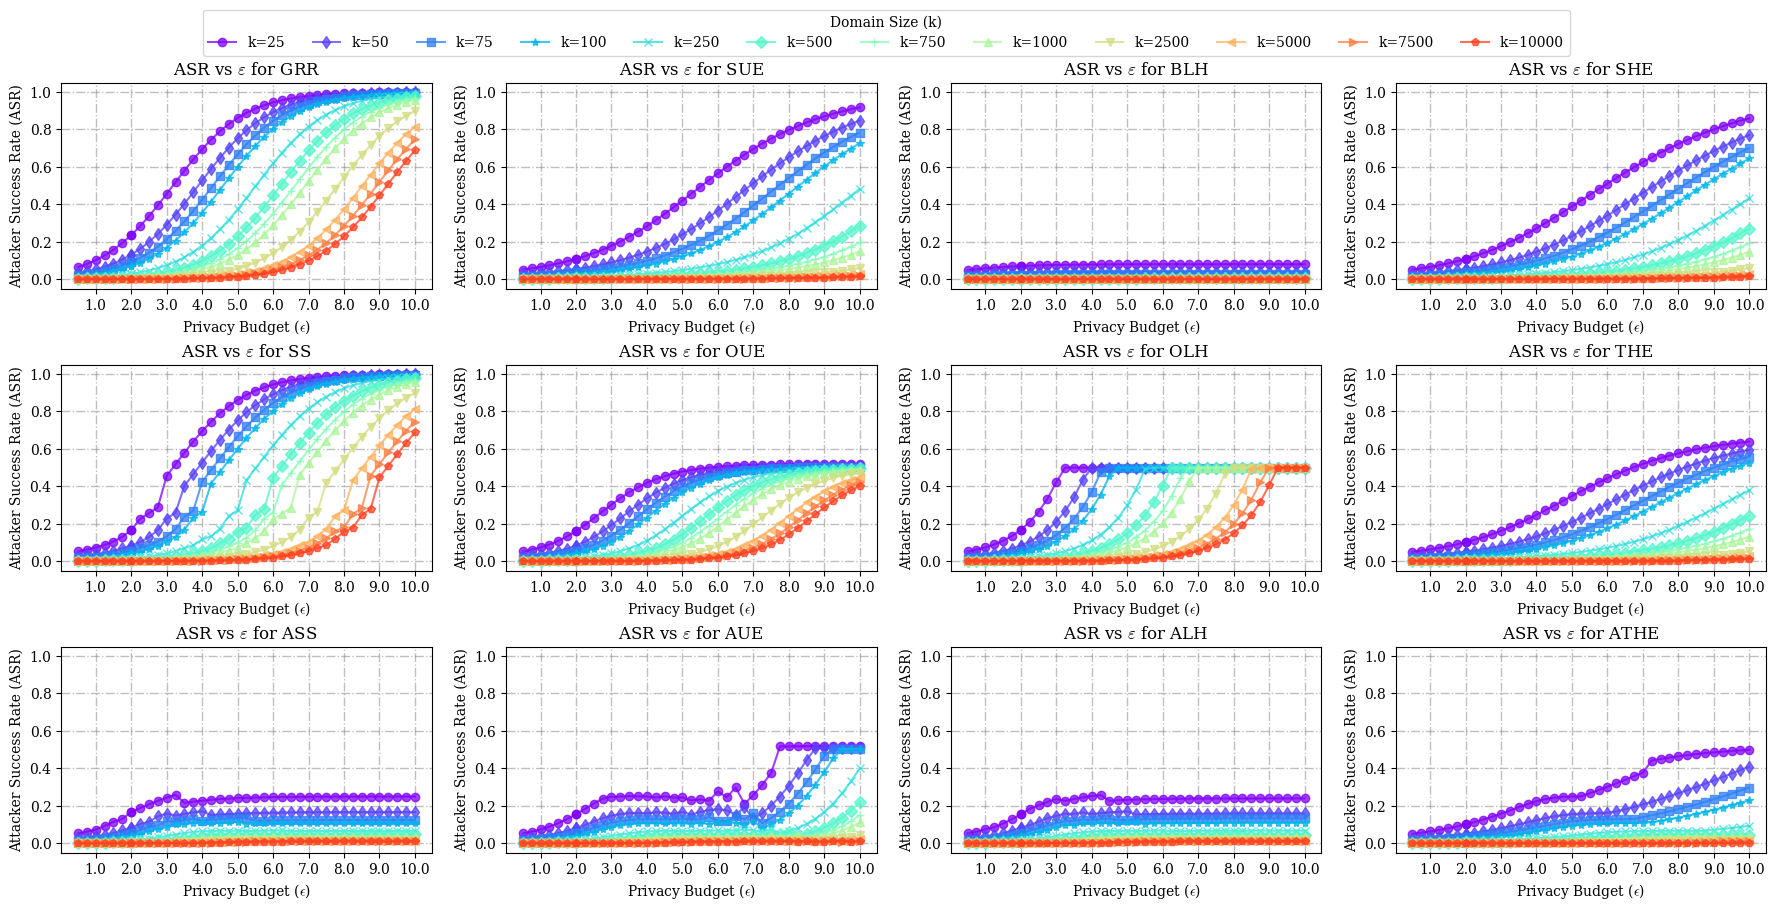

In [3]:
# Parameters
lst_k = cfg.small_domain + cfg.medium_domain + cfg.high_domain
lst_eps = list(cfg.high_privacy) + list(cfg.low_privacy)
markers = cfg.markers

# Choose a color map and generate a list of colors
cmap = matplotlib.colormaps['rainbow']  
colors = [cmap(i / len(lst_k)) for i in range(len(lst_k))]  # Normalize index to [0, 1]

# Initialize Ray using all available CPU cores
ray.shutdown() # Shutdown Ray
ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True)

@ray.remote
def compute_asr(protocol_class, k, epsilon):
    """Remote function to compute ASR for a given protocol, k, and epsilon."""
    protocol_instance = protocol_class(k, epsilon)
    asr = protocol_instance.get_asr()
    return asr

# Set up figure 
fig, axes = plt.subplots(3, 4, figsize=(22, 10.), sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.37)
axes = axes.ravel()

# Define an empty list to store legend handles and labels
handles_list = []

# Create Ray tasks for all combinations of protocols, k, and epsilon
tasks = {}
for idx, (label, protocol_class) in enumerate(protocols):
    tasks[label] = []
    for k in lst_k:
        for epsilon in lst_eps:
            task_id = compute_asr.remote(protocol_class, k, epsilon)
            tasks[label].append((k, epsilon, task_id))

# Collect the results
asr_results = {}
for label, task_list in tasks.items():
    asr_results[label] = {}
    results = ray.get([task_id for _, _, task_id in task_list])
    
    # Organize results by k value
    for (k, epsilon, _), asr in zip(task_list, results):
        if k not in asr_results[label]:
            asr_results[label][k] = []
        asr_results[label][k].append((epsilon, asr))

# Plotting the results
for idx, (label, _) in enumerate(protocols):
    ax = axes[idx]
    ax.set_title(r'ASR vs $\varepsilon$ for {label}'.format(label=label))
    ax.set_xlabel('Privacy Budget ($\epsilon$)')
    ax.set_ylabel('Attacker Success Rate (ASR)')
    ax.grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
    ax.set_xticks(np.arange(0, 10.1, 1))
    ax.set_xticklabels(np.arange(0, 10.1, 1))

    # Get the computed ASR values for the current protocol
    label_asr_results = asr_results[label]

    # Plot each line with a different marker
    for k, color, marker in zip(lst_k, colors, markers):
        lst_epsilon = [epsilon for epsilon, _ in label_asr_results[k]]
        asrs = [asr for _, asr in label_asr_results[k]]
        line, = ax.plot(lst_epsilon, asrs, label=f'k={k}', color=color, marker=marker, linestyle='-', alpha=0.75)

        # Collect the handle and label from the first subplot only to add to the global legend
        if idx == 0:
            handles_list.append((line, f'k={k}'))

# Extract handles and labels for the shared legend
handles, labels = zip(*handles_list)

# Adding a single legend above all subplots with ncols=len(lst_k)
fig.legend(handles, labels, title='Domain Size (k)', ncol=len(lst_k), loc='upper center', bbox_to_anchor=(0.5, 0.96))

# Adding axis label to all subplots
for ax in axes:
    ax.yaxis.set_tick_params(which='both', labelleft=True)  # Make y-axis tick labels visible on all subplots
    ax.xaxis.set_tick_params(which='both', labelleft=True)  # Make x-axis tick labels visible on all subplots

# Saving figure
plt.savefig('results/fig_asr_vs_epsilon_per_protocol.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Variance vs epsilon analysis: UE-, LH-, and HE-based protocols

2025-01-06 13:29:52,506	INFO worker.py:1749 -- Started a local Ray instance.


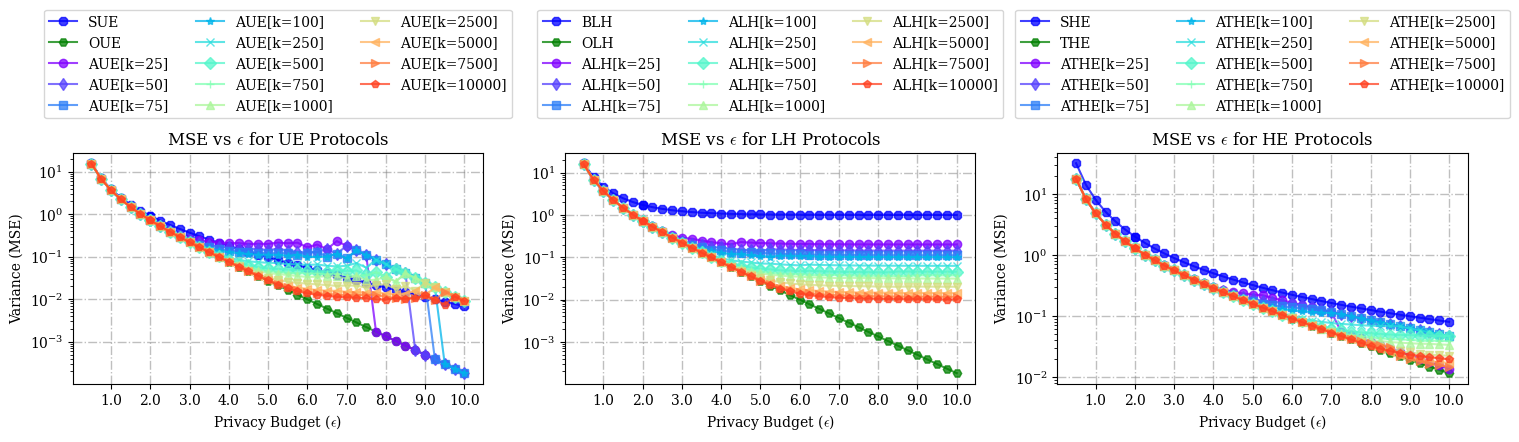

In [4]:
# Define the protocol groups
ue_protocols = [('SUE', lambda k, eps: UnaryEncoding(k, eps, optimal=False)),
                ('OUE', lambda k, eps: UnaryEncoding(k, eps, optimal=True)),
                ("AUE", AdaptiveUnaryEncoding)]

lh_protocols = [('BLH', lambda k, eps: LocalHashing(k, eps, optimal=False)),
                ('OLH', lambda k, eps: LocalHashing(k, eps, optimal=True)),
                ("ALH", AdaptiveLocalHashing)]

he_protocols = [('SHE', lambda k, eps: HistogramEncoding(k, eps, thresholding=False)),
                ('THE', lambda k, eps: HistogramEncoding(k, eps, thresholding=True)),
                ("ATHE", AdaptiveThresholdingHistogramEncoding)] 

# Combine into a single structure for convenience
all_groups = [
    ('UE', ue_protocols),
    ('LH', lh_protocols),
    ('HE', he_protocols),
]

colors_non_adaptive = ['blue', 'green']  # Non-adaptive specific colors
markers_non_adaptive = cfg.markers[::-1]

lst_k = cfg.small_domain + cfg.medium_domain + cfg.high_domain
lst_eps = list(cfg.high_privacy) + list(cfg.low_privacy)
markers = cfg.markers

# Choose a color map and generate a list of colors
cmap = matplotlib.colormaps['rainbow']  
colors = [cmap(i / len(lst_k)) for i in range(len(lst_k))]  # Normalize index to [0, 1]

# Initialize Ray
ray.shutdown()
ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True)

@ray.remote
def compute_variance(protocol_class, k, epsilon):
    """Remote function to compute variance for a given protocol, k, and epsilon."""
    protocol_instance = protocol_class(k, epsilon)
    mse = protocol_instance.get_variance()
    return mse

# Prepare figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 3.))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Legend holders
handles = []
labels = []

for ax, (group_label, protocols) in zip(axes, all_groups):
    # Compute results for all protocols and domain sizes
    tasks = {}
    for label, protocol_class in protocols:
        tasks[label] = []
        for k in lst_k:
            for epsilon in lst_eps:
                task_id = compute_variance.remote(protocol_class, k, epsilon)
                tasks[label].append((k, epsilon, task_id))

    mse_results = {}
    for label, task_list in tasks.items():
        mse_results[label] = {}
        results = ray.get([task_id for _, _, task_id in task_list])
        # Organize results by k
        for (k, epsilon, _), mse in zip(task_list, results):
            if k not in mse_results[label]:
                mse_results[label][k] = []
            mse_results[label][k].append((epsilon, mse))

    ax.set_title(f'MSE vs $\epsilon$ for {group_label} Protocols')
    ax.set_xlabel('Privacy Budget ($\epsilon$)')
    ax.set_ylabel('Variance (MSE)')
    ax.grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 10.1, 1))
    ax.set_xticklabels(np.arange(0, 10.1, 1))

    protocol_handles = []  # Store handles for legend
    protocol_labels = []  # Store labels for legend

    # Plot non-adaptive protocols
    for idx, (label, _) in enumerate(protocols[:2]):  # First two are non-adaptive
        label_mse_results = mse_results[label]
        k_fixed = lst_k[0]  # Select one domain size
        lst_epsilon = [epsilon for epsilon, _ in label_mse_results[k_fixed]]
        mses = [mse for _, mse in label_mse_results[k_fixed]]

        line, = ax.plot(lst_epsilon, mses, label=label,
                        color=colors_non_adaptive[idx],
                        marker=markers_non_adaptive[idx],
                        linestyle='-', alpha=0.75)
        protocol_handles.append(line)
        protocol_labels.append(label)

    # Plot adaptive protocols
    for label, _ in protocols[2:]:
        label_mse_results = mse_results[label]
        for k_val, color, marker in zip(lst_k, colors, markers):
            lst_epsilon = [epsilon for epsilon, _ in label_mse_results[k_val]]
            mses = [mse for _, mse in label_mse_results[k_val]]

            line, = ax.plot(lst_epsilon, mses, label=f'{label}[k={k_val}]',
                            color=color, marker=marker, linestyle='-', alpha=0.75)
            protocol_handles.append(line)
            protocol_labels.append(f'{label}[k={k_val}]')

    # Single legend for all protocols
    ax.legend(protocol_handles, protocol_labels, loc='upper center', bbox_to_anchor=(0.5, 1.65),
              ncol=3)

plt.savefig('results/fig_mse_vs_epsilon_UE_LH_HE.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()


## Variance vs epsilon analysis: UE-, LH-, and HE-based protocols

2025-01-06 13:36:17,348	INFO worker.py:1749 -- Started a local Ray instance.


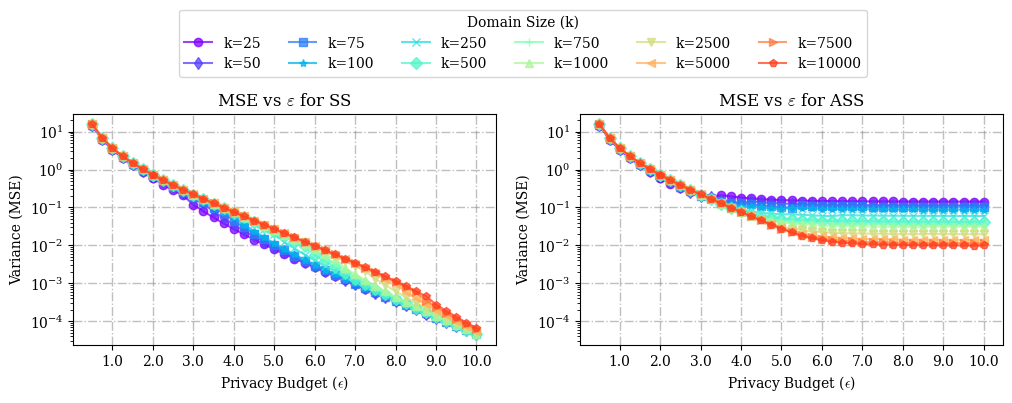

In [5]:
filtered_protocols = [  
                        ('SS', SubsetSelection),
                        ("ASS", AdaptiveSubsetSelection)
                     ]

# Parameters
markers = cfg.markers
lst_k = cfg.small_domain + cfg.medium_domain + cfg.high_domain
lst_eps = list(cfg.high_privacy) + list(cfg.low_privacy)

# Choose a color map and generate a list of colors
cmap = matplotlib.colormaps['rainbow']  
colors = [cmap(i / len(lst_k)) for i in range(len(lst_k))]  # Normalize index to [0, 1]

# Initialize Ray using all available CPU cores
ray.shutdown()
ray.init(num_cpus=os.cpu_count())

@ray.remote
def compute_variance(protocol_class, k, epsilon):
    """Remote function to compute variance for a given protocol, k, and epsilon."""
    protocol_instance = protocol_class(k, epsilon)
    mse = protocol_instance.get_variance()
    return mse

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(12, 3.), sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.32)
axes = axes.ravel()  

# Define an empty list to store legend handles and labels
handles_list = []

# Create Ray tasks for all combinations of filtered_protocols, k, and epsilon
tasks = {}
for idx, (label, protocol_class) in enumerate(filtered_protocols):
    tasks[label] = []
    for k in lst_k:
        for epsilon in lst_eps:
            task_id = compute_variance.remote(protocol_class, k, epsilon)
            tasks[label].append((k, epsilon, task_id))

# Collect the results
mse_results = {}
for label, task_list in tasks.items():
    mse_results[label] = {}
    results = ray.get([task_id for _, _, task_id in task_list])
    
    # Organize results by k value
    for (k, epsilon, _), mse in zip(task_list, results):
        if k not in mse_results[label]:
            mse_results[label][k] = []
        mse_results[label][k].append((epsilon, mse))

# Plotting the results
for idx, (label, _) in enumerate(filtered_protocols):
    ax = axes[idx]
    ax.set_title(r'MSE vs $\varepsilon$ for {label}'.format(label=label))
    ax.set_xlabel('Privacy Budget ($\epsilon$)')
    ax.set_ylabel('Variance (MSE)')
    ax.grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
    ax.set_xticks(np.arange(0, 10.1, 1))
    ax.set_xticklabels(np.arange(0, 10.1, 1))
    ax.set_yscale('log')

    # Get the computed MSE values for the current protocol
    label_mse_results = mse_results[label]

    # Plot each line with a different marker
    for k, color, marker in zip(lst_k, colors, markers):
        lst_epsilon = [epsilon for epsilon, _ in label_mse_results[k]]
        mses = [mse for _, mse in label_mse_results[k]]
        line, = ax.plot(lst_epsilon, mses, label=f'k={k}', color=color, marker=marker, linestyle='-', alpha=0.75)

        # Collect the handle and label from the first subplot only to add to the global legend
        if idx == 0:
            handles_list.append((line, f'k={k}'))

# Extract handles and labels for the shared legend
handles, labels = zip(*handles_list)

# Adding a single legend above all subplots with ncols=len(lst_k)
fig.legend(handles, labels, title='Domain Size (k)', ncol=6, loc='upper center', bbox_to_anchor=(0.5, 1.25))

# Adding axis label to all subplots
for ax in axes:
    ax.yaxis.set_tick_params(which='both', labelleft=True)  # Make y-axis tick labels visible on all subplots
    ax.xaxis.set_tick_params(which='both', labelleft=True)  # Make x-axis tick labels visible on all subplots

# Saving figure
plt.savefig('results/fig_mse_vs_epsilon_SS_vs_ASS.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

## ASR-MSE Pareto frontier for all protocols (Analytical)

2024-12-19 23:00:59,648	INFO worker.py:1749 -- Started a local Ray instance.


Running analysis: high_priv_small_domain


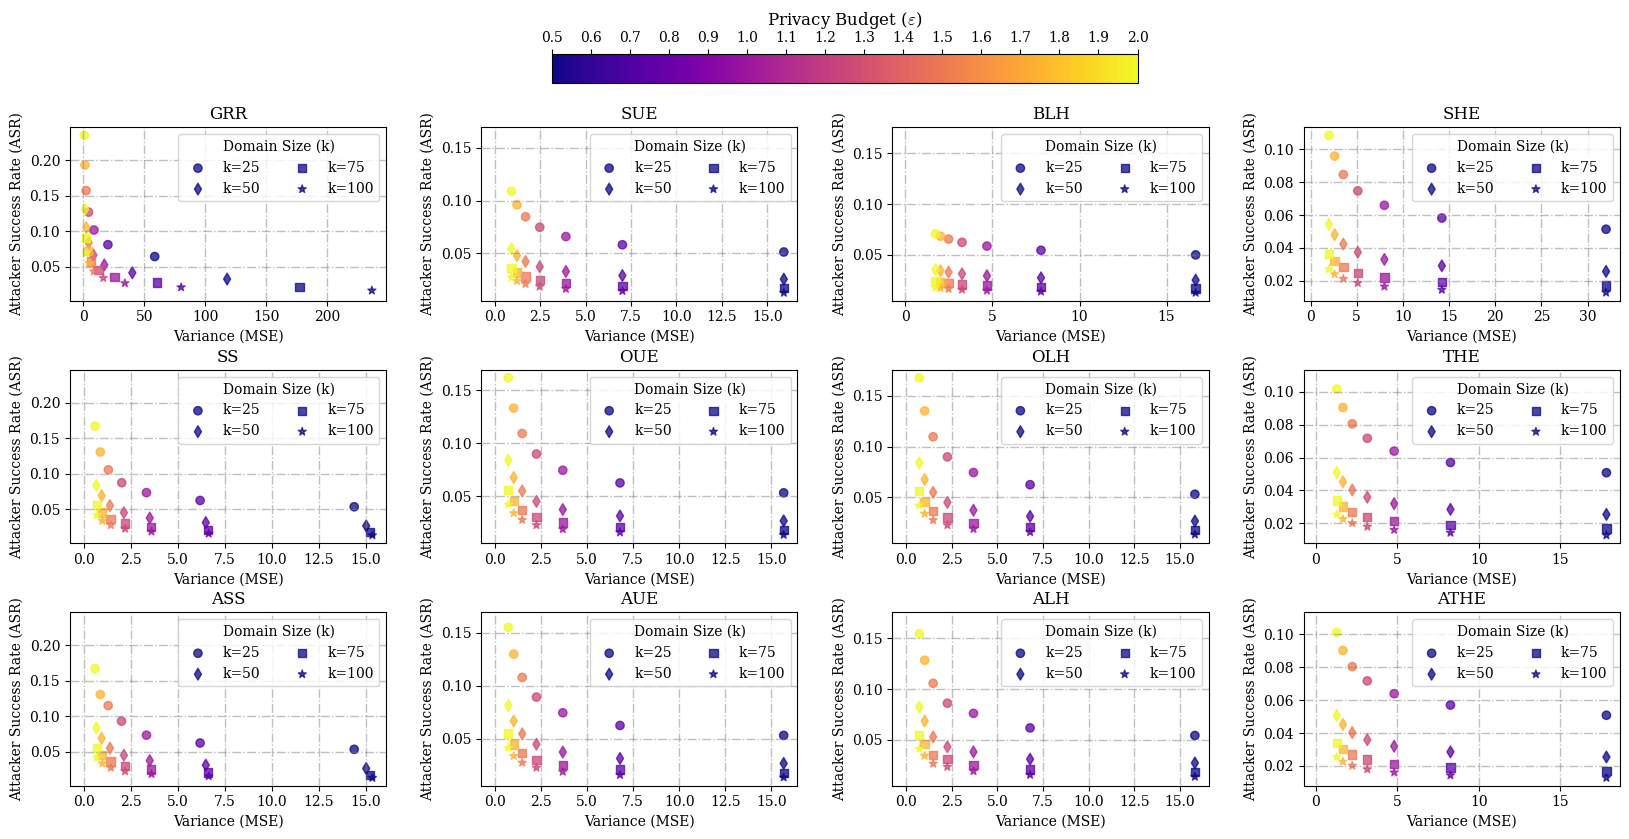

Running analysis: high_priv_medium_domain


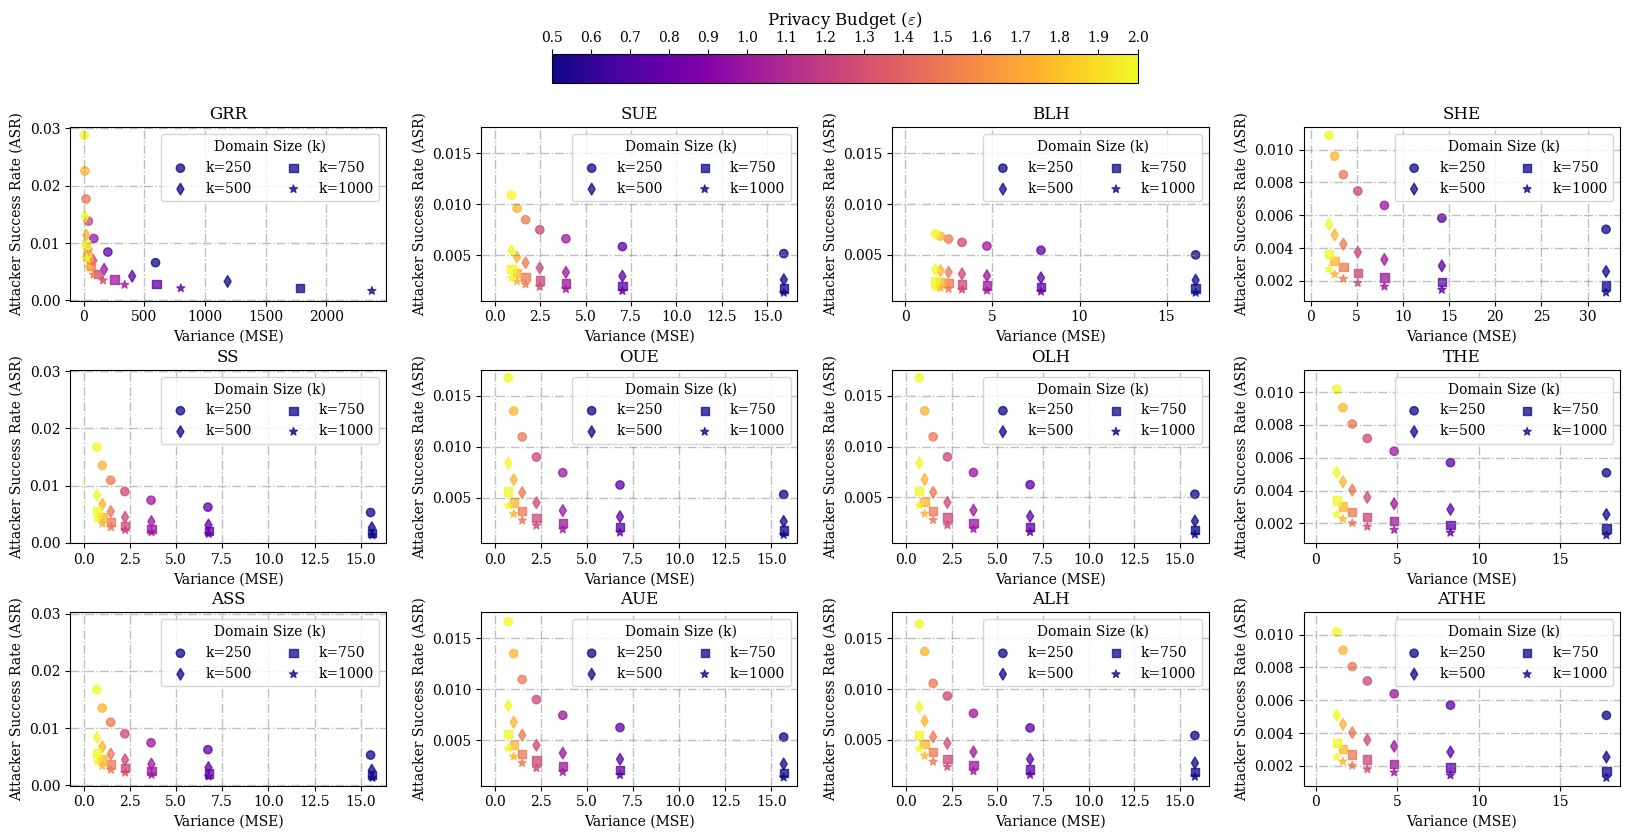

Running analysis: high_priv_large_domain


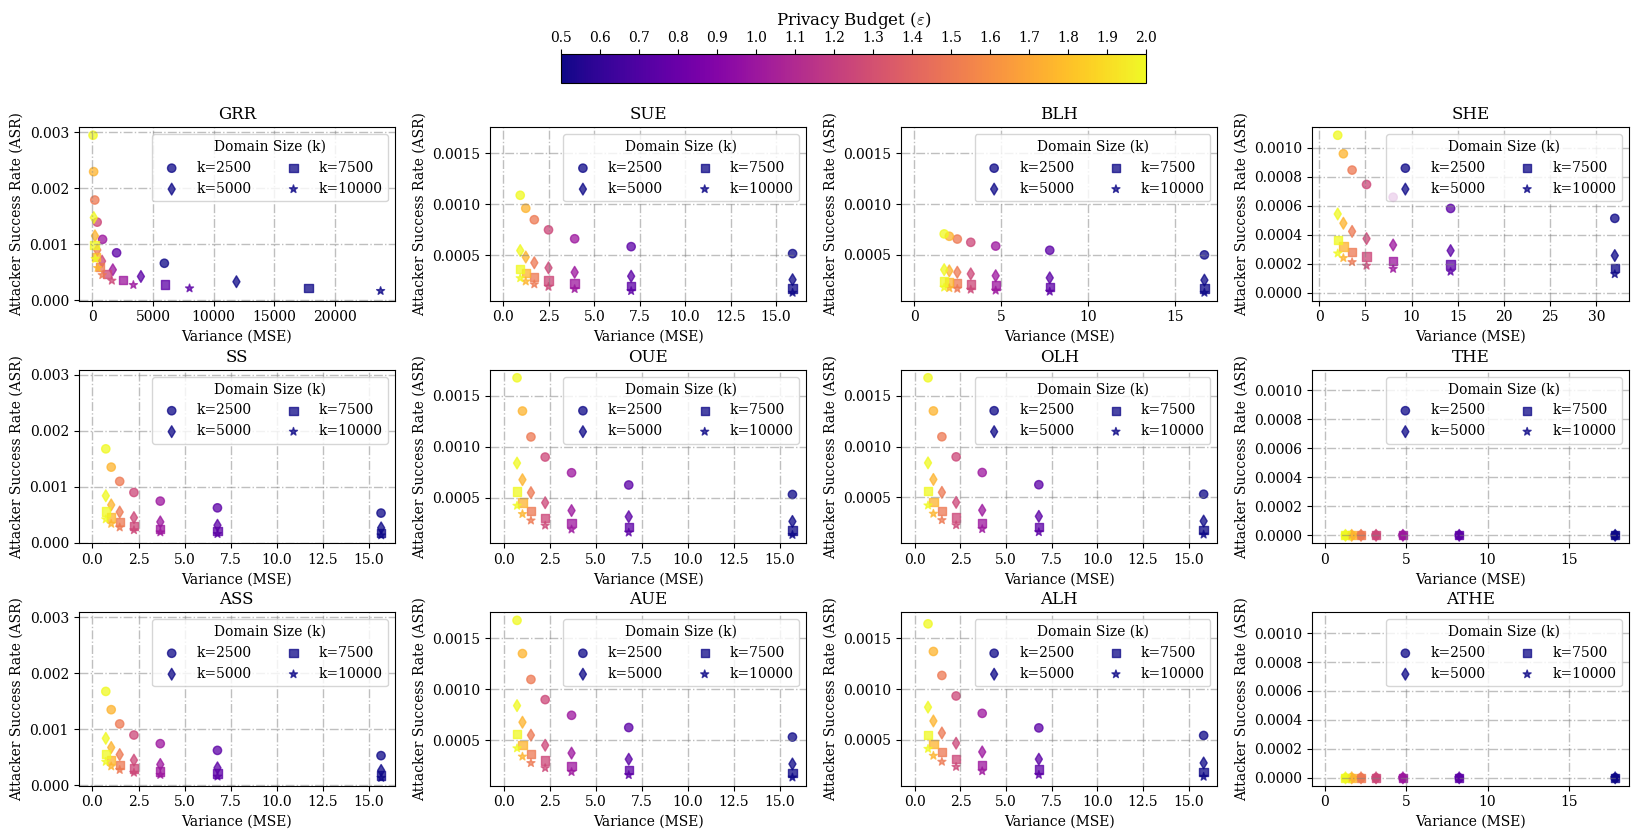

Running analysis: low_priv_small_domain


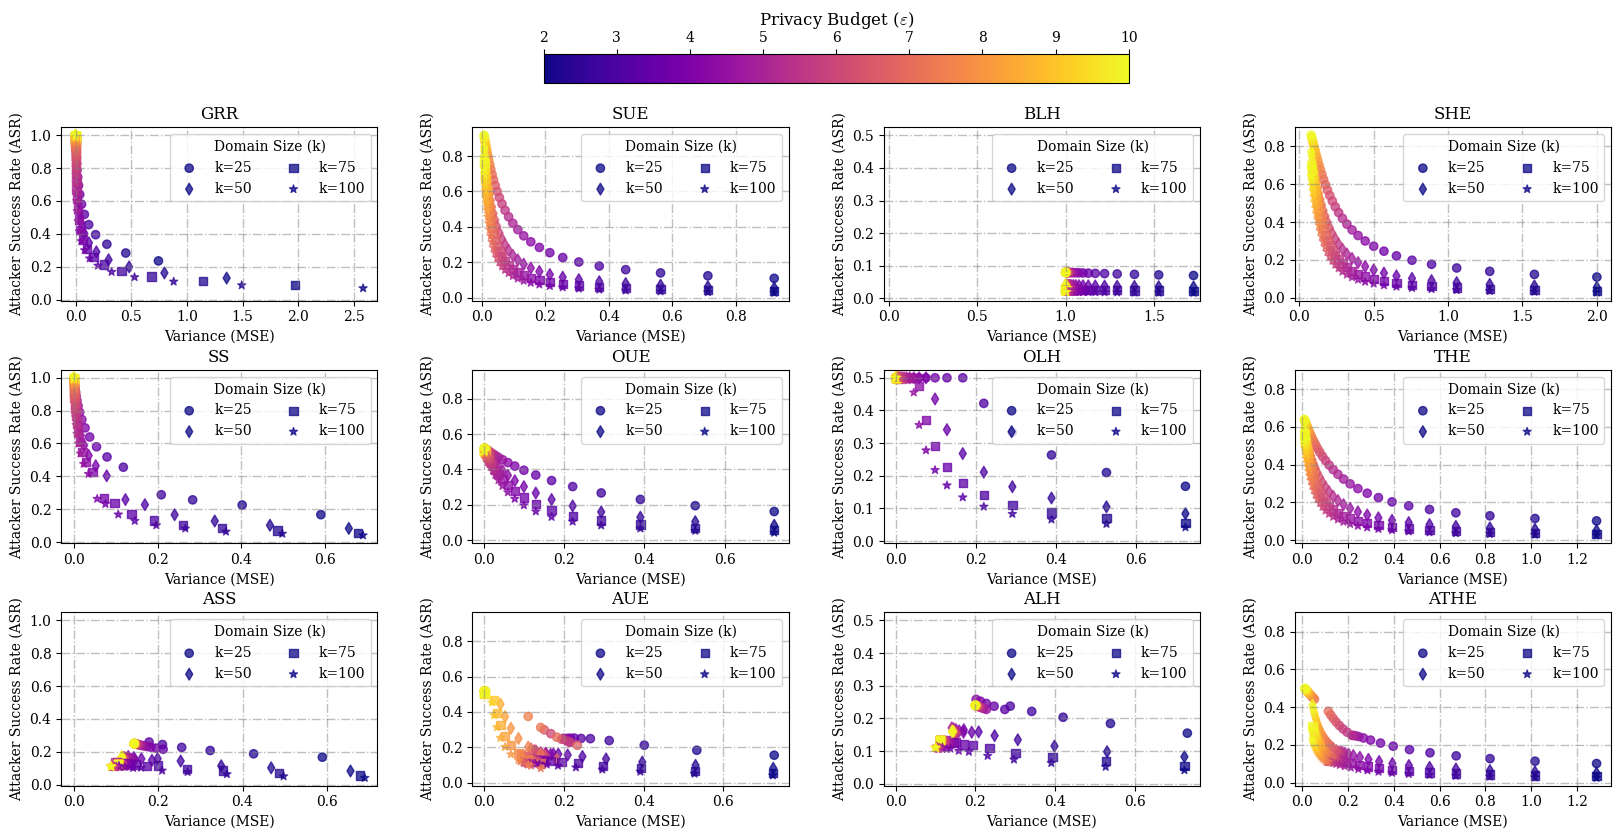

Running analysis: low_priv_medium_domain


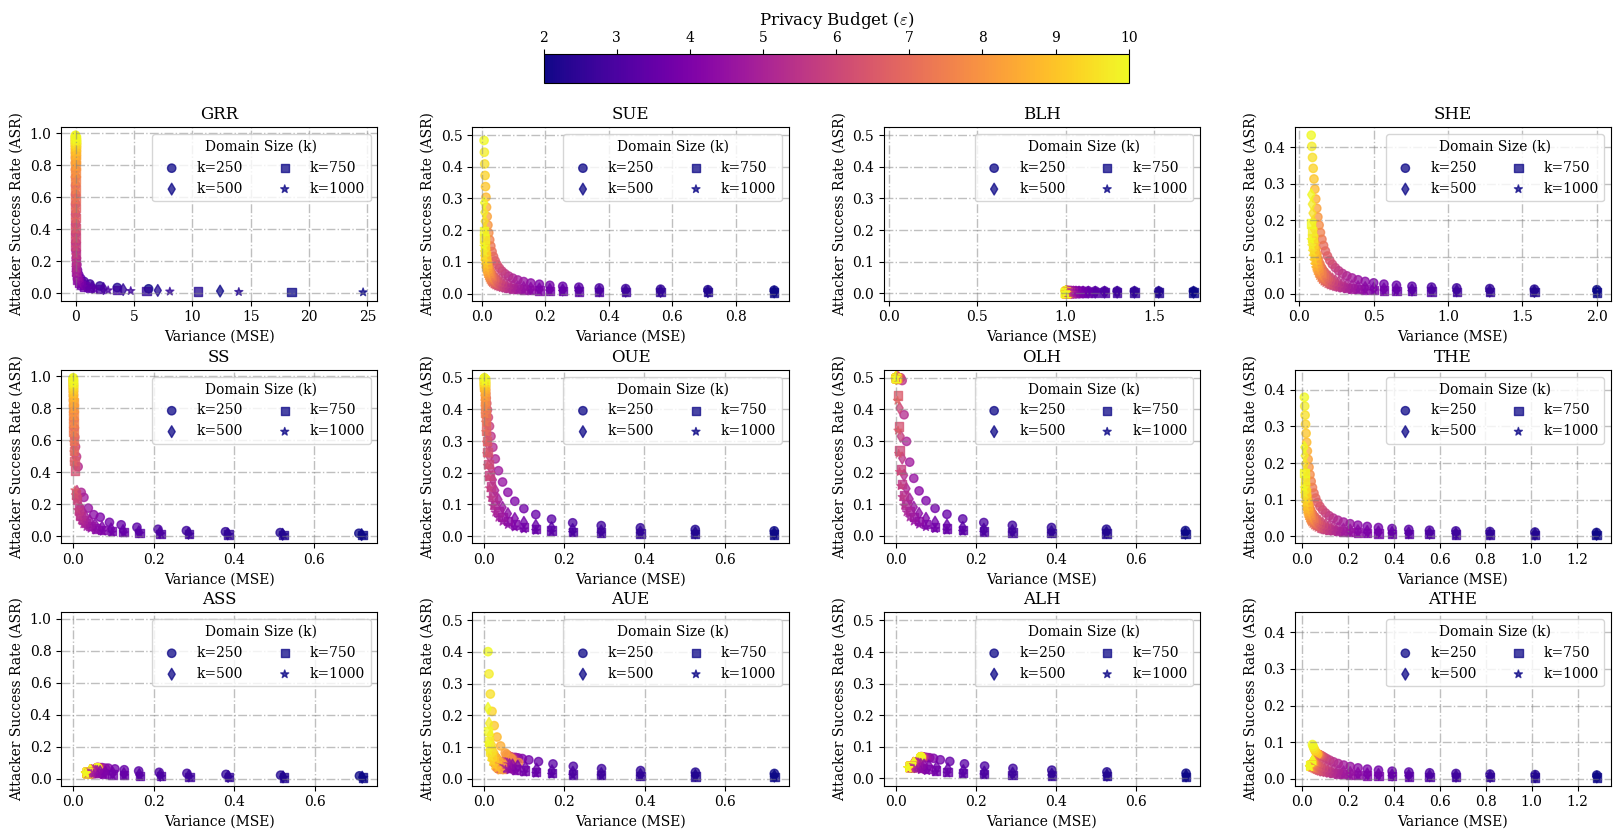

Running analysis: low_priv_large_domain


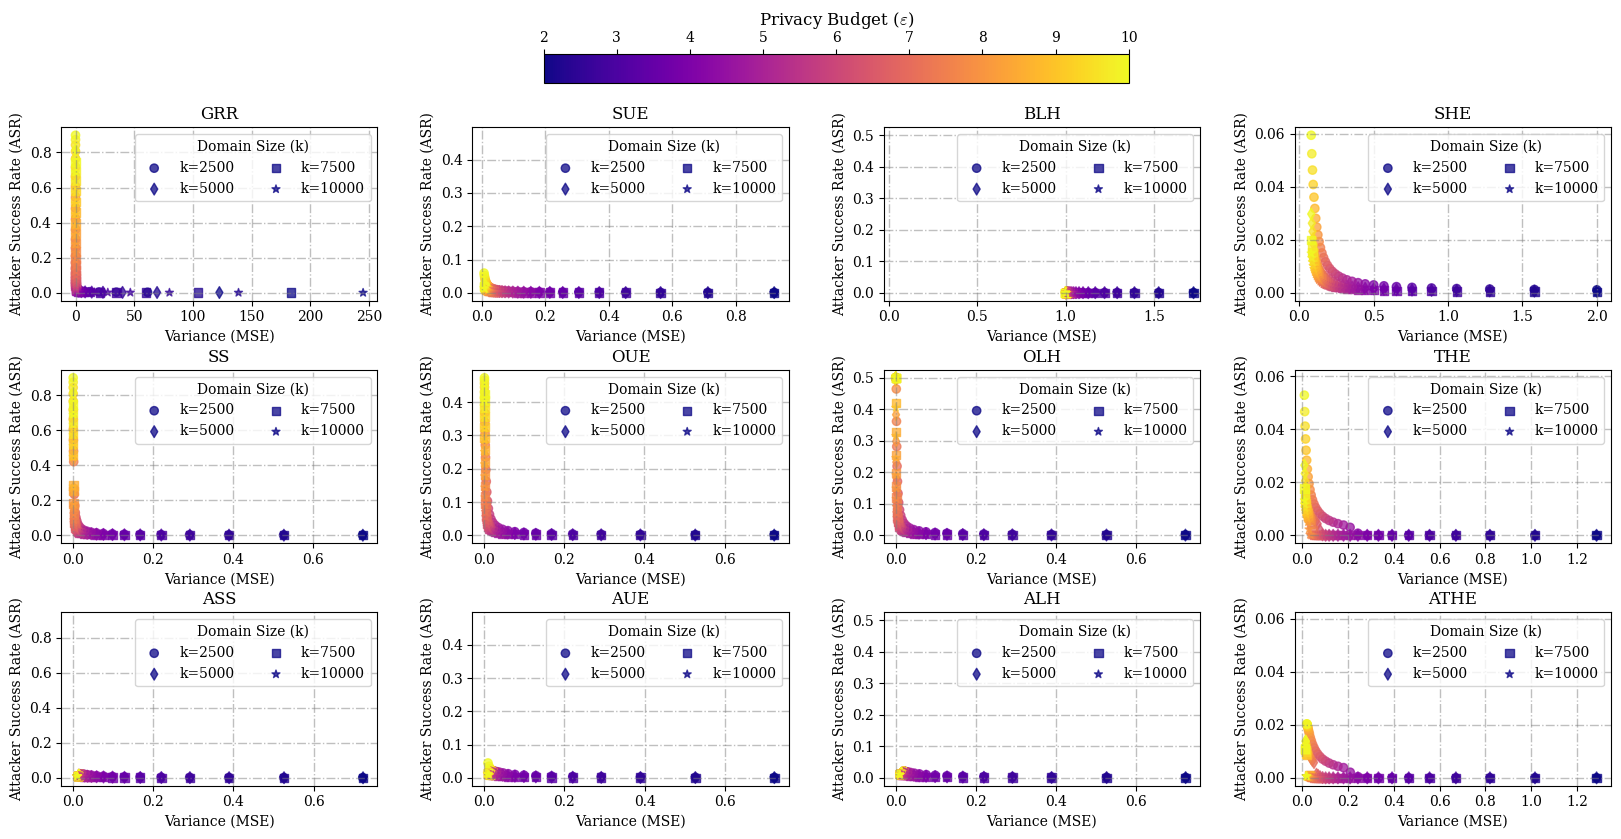

In [ ]:
# Markers
markers = cfg.markers

# Define domain sizes
small_domain = cfg.small_domain
medium_domain = cfg.medium_domain
high_domain = cfg.high_domain

# Define privacy regimes
high_privacy = cfg.high_privacy
low_privacy = cfg.low_privacy

# Analyses
dic_analyses = cfg.dic_analyses

# Initialize Ray using all available CPU cores
ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True)

@ray.remote
def compute_variance_asr(protocol_class, k, epsilon):
    """Remote function to compute variance and ASR for a given protocol, k, and epsilon."""
    protocol_instance = protocol_class(k, epsilon)
    variance = protocol_instance.get_variance()
    asr = protocol_instance.get_asr()
    return variance, asr

# Run analyses in parallel
for analysis in dic_analyses.keys():
    print(f"Running analysis: {analysis}")

    # Getting parameters of the analysis
    lst_k = dic_analyses[analysis]["k"]
    lst_eps = dic_analyses[analysis]["lst_eps"]

    # Set up the figure
    fig, axes = plt.subplots(3, 4, figsize=(20, 9.5), sharey='col')
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    axes = axes.ravel() 

    # Create a color map for epsilon values
    cmap = cm.plasma
    norm = matplotlib.colors.Normalize(vmin=lst_eps.min(), vmax=lst_eps.max())

    # Compute variance and ASR in parallel for each protocol, k, and epsilon
    for idx, (label, protocol_class) in enumerate(protocols):
        ax = axes[idx]
        ax.set_title(label)
        ax.set_xlabel('Variance (MSE)')
        ax.set_ylabel('Attacker Success Rate (ASR)')
        ax.grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)

        tasks = []
        for k, marker in zip(lst_k, markers):
            for epsilon in lst_eps:
                task = compute_variance_asr.remote(protocol_class, k, epsilon)
                tasks.append((task, k, marker, epsilon))

        results = ray.get([task for task, _, _, _ in tasks])

        # Organize results
        variance_asr_results = {}
        for (variance, asr), (_, k, marker, epsilon) in zip(results, tasks):
            if k not in variance_asr_results:
                variance_asr_results[k] = {"variances": [], "asrs": [], "marker": marker}
            variance_asr_results[k]["variances"].append(variance)
            variance_asr_results[k]["asrs"].append(asr)

        # Plot results for each k value
        for k, result in variance_asr_results.items():
            variances = result["variances"]
            asrs = result["asrs"]
            marker = result["marker"]
            ax.scatter(variances, asrs, label=f'k={k}', marker=marker, c=lst_eps, cmap=cmap, norm=norm, alpha=0.75)

        if idx > 0 and "high_priv" in analysis:
            ax.set_xlim(-0.75)  
        elif idx > 0 and "low_priv" in analysis:
            ax.set_xlim(-0.03)  
        ax.legend(title='Domain Size (k)', ncols=2)

    # Add a color bar to represent the epsilon values, placing it on top of the subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy data for color bar
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.06, location='top')
    cbar.set_label(r'Privacy Budget ($\varepsilon$)', fontsize=12)

    if "low_priv" in analysis:
        cbar.set_ticks(np.arange(lst_eps.min(), lst_eps.max()+0.5))
    else:
        cbar.set_ticks(np.arange(0.5, 2.1, 0.1))

    # Adding axis label to all subplots
    for ax in axes:
        ax.yaxis.set_tick_params(which='both', labelleft=True)  
        ax.xaxis.set_tick_params(which='both', labelleft=True)  

    # Saving figure
    plt.savefig(f'results/fig_priv_util_asr_tradeoff_{analysis}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    print("=====================================================================================")

# Shutdown Ray
ray.shutdown()


## ASR-MSE Pareto frontier for all protocols (Empirical)

The code below took a few CPU hours to execute (~5.5h using 32 logical cores - intel i9, 3.2GHz)

GRR
SUE
BLH
SHE
SS
OUE
OLH
THE
ASS
AUE
ALH
ATHE


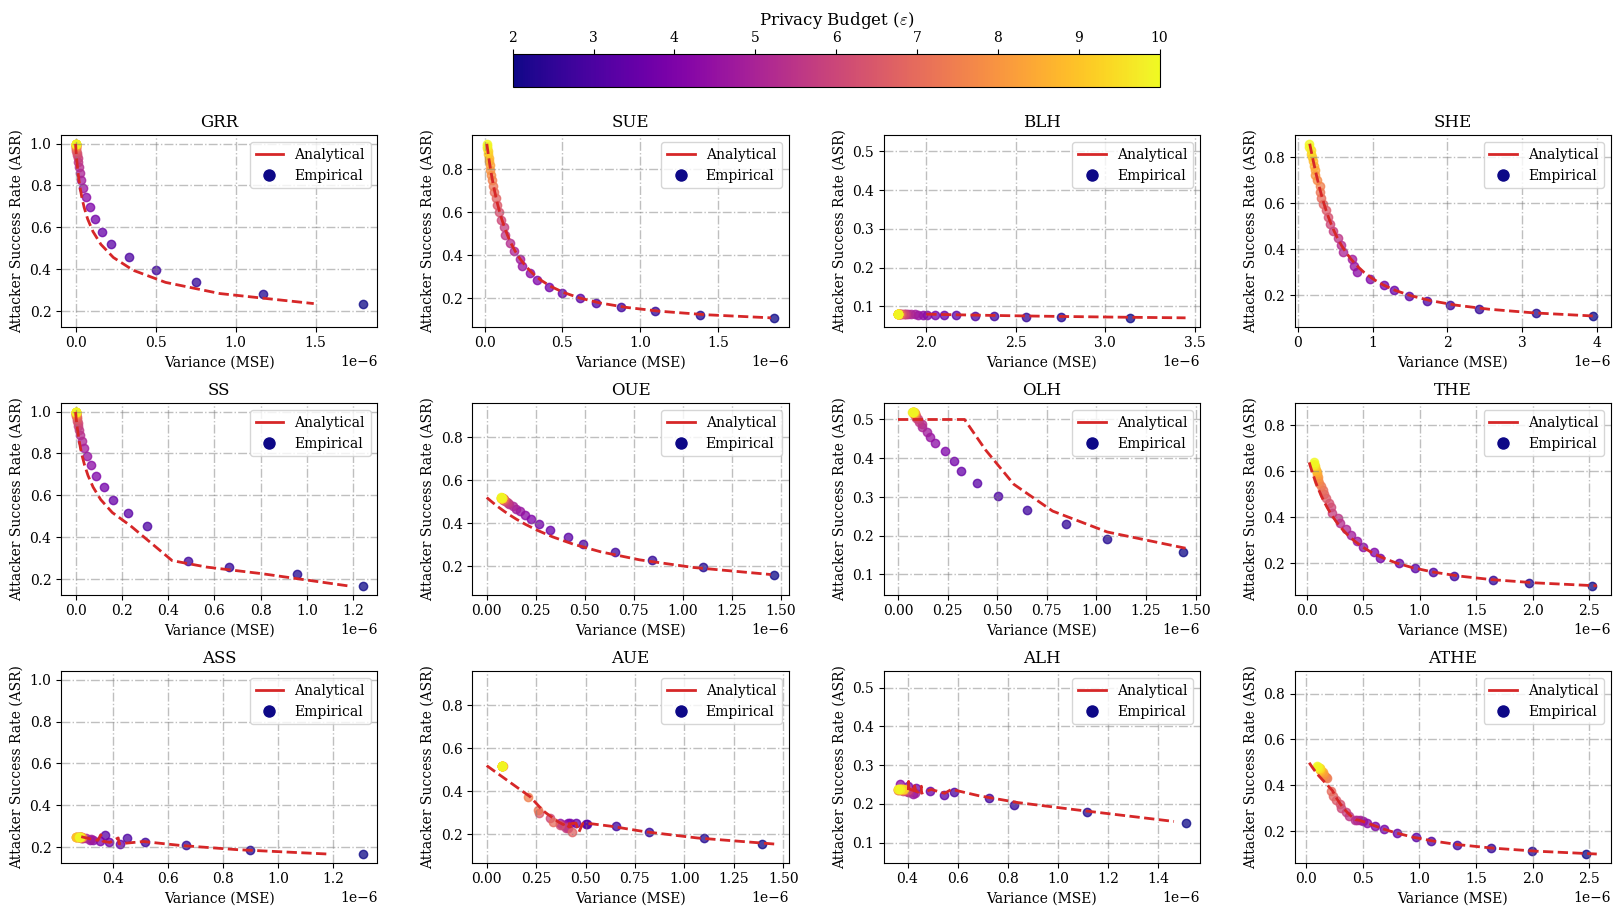

In [2]:
ray.shutdown()
ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True, logging_level=logging.ERROR)

# List of protocols to analyze
def initialize_protocols(k, epsilon):
    return [
        ("GRR", GeneralizedRandomizedResponse(k, epsilon)),
        ("SUE", UnaryEncoding(k, epsilon, optimal=False)),
        ("BLH", LocalHashing(k, epsilon, optimal=False)),
        ("SHE", HistogramEncoding(k, epsilon, thresholding=False)),
        ("SS", SubsetSelection(k, epsilon)),
        ("OUE", UnaryEncoding(k, epsilon, optimal=True)),        
        ("OLH", LocalHashing(k, epsilon, optimal=True)),
        ("THE", HistogramEncoding(k, epsilon, thresholding=True)),      
        ("ASS", AdaptiveSubsetSelection(k, epsilon)),
        ("AUE", AdaptiveUnaryEncoding(k, epsilon)),        
        ("ALH", AdaptiveLocalHashing(k, epsilon)),
        ("ATHE", AdaptiveThresholdingHistogramEncoding(k, epsilon)),
    ]

# Generate synthetic data
def generate_synthetic_data(n, k, alpha=None, alpha_randomness=1.0, seed=42):
    """Generate synthetic discrete data using Dirichlet distribution."""
    np.random.seed(seed)
    alpha = np.random.uniform(0.1, alpha_randomness, size=k) if alpha is None else np.asarray(alpha)
    probabilities = np.random.dirichlet(alpha, size=n)
    data = np.array([np.random.choice(k, p=prob) for prob in probabilities])
    return data

@ray.remote
def compute_empirical_asr_mse(protocol, data, seed):
    """
    Compute empirical MSE and ASR for a protocol instance.
    """
    np.random.seed(seed)
    k = protocol.k
    true_freq = np.zeros(k)
    for val in data:
        true_freq[val]+=1
    true_freq = true_freq/len(data)
    noisy_reports = [protocol.obfuscate(val) for val in data]
    estimated_freq = protocol.estimate(noisy_reports)
    
    # Empirical ASR
    correct_predictions = sum(protocol.attack(noisy_reports[i]) == val for i, val in enumerate(data))
    asr = correct_predictions / len(data)
    
    # Empirical MSE
    mse = np.mean((true_freq - estimated_freq) ** 2)
    return mse, asr

# Parameters
n = int(5e5)  # Number of users
k = 25        # Fixed domain size
lst_eps = cfg.low_privacy # Low to medium privacy regimes
nb_seeds = int(os.cpu_count() * 3)

# Generate synthetic data
data = generate_synthetic_data(n, k)

# Set up the figure for 3 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 10.5), sharey='col')
plt.subplots_adjust(wspace=0.3, hspace=0.4)
axes = axes.ravel()  # Flatten axes array for easier indexing

# Color map for epsilon
cmap = cm.plasma
norm = matplotlib.colors.Normalize(vmin=lst_eps.min(), vmax=lst_eps.max())

protocols = initialize_protocols(k, 2)  # Initialize with placeholder epsilon
for idx, (protocol_name, _) in enumerate(protocols):
    print(protocol_name)

    ax = axes[idx]
    ax.set_title(protocol_name)
    ax.set_xlabel('Variance (MSE)')
    ax.set_ylabel('Attacker Success Rate (ASR)')
    ax.grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)

    # Analytical results storage
    analytical_mse_list = []
    analytical_asr_list = []

    empirical_mse = []
    empirical_asr = []

    for epsilon in lst_eps:
        # Initialize protocol with current epsilon
        protocol = initialize_protocols(k, epsilon)[idx][1]

        # Analytical results
        analytical_mse = protocol.get_variance() / n
        analytical_asr = protocol.get_asr()
        analytical_mse_list.append(analytical_mse)
        analytical_asr_list.append(analytical_asr)

        # Empirical results (parallelized)
        tasks = [compute_empirical_asr_mse.remote(protocol, data, seed) for seed in range(nb_seeds)]
        results = ray.get(tasks)
        mse_values, asr_values = zip(*results)
        empirical_mse.append(np.mean(mse_values))
        empirical_asr.append(np.mean(asr_values))

        # Plot empirical results as scatter points
        ax.scatter(np.mean(mse_values), np.mean(asr_values), color=cmap(norm(epsilon)), alpha=0.75, label="_nolegend_")

    # Sort analytical results for line plotting
    sorted_indices = np.argsort(analytical_mse_list)
    sorted_mse = np.array(analytical_mse_list)[sorted_indices]
    sorted_asr = np.array(analytical_asr_list)[sorted_indices]

    # Plot analytical Pareto frontier as a line
    ax.plot(sorted_mse, sorted_asr, color="tab:red", linestyle="--", linewidth=2, label="_nolegend_")

    # Custom legend for both Analytical and Empirical
    custom_lines = [
        Line2D([0], [0], color="tab:red", linewidth=2, label="Analytical"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(lst_eps[0])), markersize=10, label="Empirical")
    ]
    ax.legend(handles=custom_lines, loc="upper right")

# Add a color bar to represent the epsilon values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy data for color bar
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.04, pad=0.06, location='top')
cbar.set_label(r'Privacy Budget ($\varepsilon$)', fontsize=12)

# Hide unused axes
for i in range(len(protocols), len(axes)):
    axes[i].axis('off')

# Saving figure
plt.savefig(f'results/fig_asr_mse_analytical_vs_empirical.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()


## "Pareto Frontier" Analytical Analysis for Adaptive vs State-Of-The-Art Protocols (Teaser Figure)

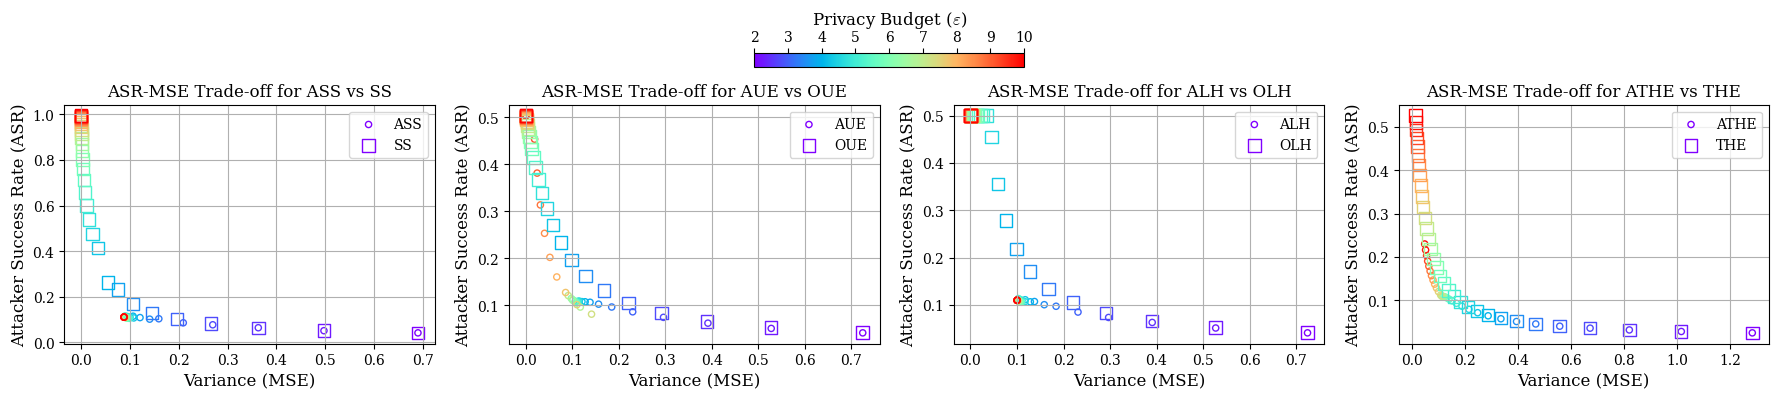

In [7]:
# Define protocols and parameters
protocols = [
    (SubsetSelection, AdaptiveSubsetSelection),
    (UnaryEncoding, AdaptiveUnaryEncoding),
    (LocalHashing, AdaptiveLocalHashing),
    (HistogramEncoding, AdaptiveThresholdingHistogramEncoding)
]
protocol_names = [
    ("SS", "ASS"),
    ("OUE", "AUE"),
    ("OLH", "ALH"),
    ("THE", "ATHE")
]

# Define a colormap and markers for the plots
colors = matplotlib.colormaps['rainbow'] 

markers_dict = {
    "SS": "s",
    "ASS": ".",
    "OUE": "s",
    "AUE": ".",
    "OLH": "s",
    "ALH": ".",
    "THE": "s",
    "ATHE": "."
}

# Function to get ASR and Variance for given protocol and epsilon
def get_asr_variance(protocol_class, epsilon, k):
    protocol_instance = protocol_class(k, epsilon)
    asr = protocol_instance.get_asr()  # Example function to get ASR
    variance = protocol_instance.get_variance()  # Example function to get Variance
    return asr, variance

# Privacy budgets to evaluate
epsilon_values = np.arange(2, 10.1, 0.25)

# Fixed domain size
k = 100

# Plotting setup for a single-row teaser figure
fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))

# Collect ASR and Variance values for each protocol and epsilon, then plot
for idx, ((adaptive_protocol, non_adaptive_protocol), (adaptive_name, non_adaptive_name)) in enumerate(zip(protocols, protocol_names)):
    results = []
    for protocol, protocol_name in zip([non_adaptive_protocol, adaptive_protocol], [non_adaptive_name, adaptive_name]):
        for epsilon in epsilon_values:
            asr, variance = get_asr_variance(protocol, epsilon, k)
            results.append((variance, asr, protocol_name, epsilon))

    # Get the appropriate subplot axes
    ax = axes[idx]
    
    for variance, asr, protocol_name, epsilon in results:
        # Use colormap based on epsilon value (normalize by dividing by max epsilon value)
        color = colors((epsilon - min(epsilon_values)) / (max(epsilon_values) - min(epsilon_values)))
        ax.scatter(variance, asr, color=color, marker=markers_dict[protocol_name], s=80, facecolors='none', alpha=1,
                   label=protocol_name if epsilon == epsilon_values[0] else "")

    # Customize the subplot
    ax.set_title(f'ASR-MSE Trade-off for {non_adaptive_name} vs {adaptive_name}', fontsize=12)
    ax.set_xlabel('Variance (MSE)', fontsize=12)
    ax.set_ylabel('Attacker Success Rate (ASR)', fontsize=12)
    ax.grid(True)

    # Fix legend to display only one label per protocol
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels, loc='best', fontsize=10)

# Add a single colorbar for all subplots
norm = plt.Normalize(vmin=min(epsilon_values), vmax=max(epsilon_values))
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.25, pad=0.06, location='top')
cbar.set_label(r'Privacy Budget ($\varepsilon$)', fontsize=12)
cbar.set_ticks(np.arange(epsilon_values.min(), epsilon_values.max() + 0.1, 1))
cbar.ax.set_position([0.1, 0.725, 0.8, 0.03])  # Adjust the position to move it above the subplots)
# Adjust the layout and show the plot
# fig.tight_layout()
plt.savefig('results/fig_asr_mse_pareto_frontier_analytical.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()


## "Pareto Frontier" Empirical Analysis for Adaptive vs State-Of-The-Art Protocols

The code below took several CPU hours to execute (~11.5h using 32 logical cores - intel i9, 3.2GHz)

2025-01-07 03:53:01,690	INFO worker.py:1749 -- Started a local Ray instance.


SS ASS
OUE AUE
OLH ALH
THE ATHE


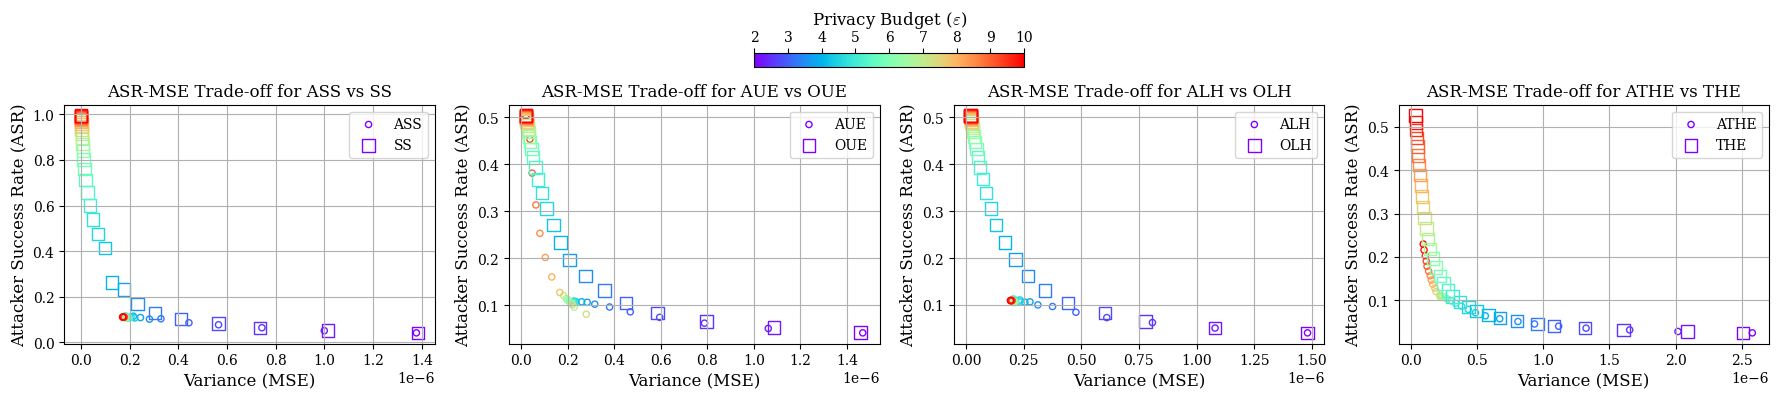

In [3]:
# Initialize Ray for parallel processing
ray.shutdown()
ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True)

# Define protocols and parameters
protocols = [
    (SubsetSelection, AdaptiveSubsetSelection),
    (UnaryEncoding, AdaptiveUnaryEncoding),
    (LocalHashing, AdaptiveLocalHashing),
    (HistogramEncoding, AdaptiveThresholdingHistogramEncoding)
]
protocol_names = [
    ("SS", "ASS"),
    ("OUE", "AUE"),
    ("OLH", "ALH"),
    ("THE", "ATHE")
]

# Define a colormap and markers for the plots
colors = matplotlib.colormaps['rainbow'] 
markers_dict = {
    "SS": "s",
    "ASS": ".",
    "OUE": "s",
    "AUE": ".",
    "OLH": "s",
    "ALH": ".",
    "THE": "s",
    "ATHE": "."
}

# Function to compute empirical ASR and variance
@ray.remote
def compute_empirical_asr_variance(protocol_class, k, epsilon, data, seed):
    np.random.seed(seed)
    protocol = protocol_class(k, epsilon)
    noisy_reports = [protocol.obfuscate(val) for val in data]
    estimated_freq = protocol.estimate(noisy_reports)
    true_freq = np.bincount(data, minlength=k) / len(data)
    mse = np.mean((true_freq - estimated_freq) ** 2)
    correct_predictions = sum(protocol.attack(noisy_reports[i]) == data[i] for i in range(len(data)))
    asr = correct_predictions / len(data)
    return mse, asr

# Generate synthetic data
def generate_synthetic_data(n, k, seed=42):
    np.random.seed(seed)
    return np.random.randint(0, k, n)

n = int(5e5)  # Number of users
k = 100        # Fixed domain size
epsilon_values = np.arange(2, 10.1, 0.25)
nb_seeds = 100  # Number of seeds
data = generate_synthetic_data(n, k)

# Plotting setup for a single-row teaser figure
fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))

for idx, ((adaptive_protocol, non_adaptive_protocol), (adaptive_name, non_adaptive_name)) in enumerate(zip(protocols, protocol_names)):
    print(adaptive_name, non_adaptive_name)
    results = []
    for protocol_class, protocol_name in zip([non_adaptive_protocol, adaptive_protocol], [non_adaptive_name, adaptive_name]):
        tasks = []
        for epsilon in epsilon_values:
            for seed in range(nb_seeds):
                tasks.append(compute_empirical_asr_variance.remote(protocol_class, k, epsilon, data, seed))
        
        task_results = ray.get(tasks)
        # Average results over seeds
        for i, epsilon in enumerate(epsilon_values):
            subset_results = task_results[i * nb_seeds:(i + 1) * nb_seeds]
            mse_values, asr_values = zip(*subset_results)
            results.append((np.mean(mse_values), np.mean(asr_values), protocol_name, epsilon))

    # Get the appropriate subplot axes
    ax = axes[idx]
    for variance, asr, protocol_name, epsilon in results:
        # Use colormap based on epsilon value (normalize by dividing by max epsilon value)
        color = colors((epsilon - min(epsilon_values)) / (max(epsilon_values) - min(epsilon_values)))
        ax.scatter(variance, asr, color=color, marker=markers_dict[protocol_name], s=80, facecolors='none', alpha=1, label=protocol_name if epsilon == epsilon_values[0] else "")

    # Customize the subplot
    ax.set_title(f'ASR-MSE Trade-off for {non_adaptive_name} vs {adaptive_name}', fontsize=12)
    ax.set_xlabel('Variance (MSE)', fontsize=12)
    ax.set_ylabel('Attacker Success Rate (ASR)', fontsize=12)
    ax.grid(True)

    # Fix legend to display only one label per protocol
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)
    ax.legend(unique_handles, unique_labels, loc='best', fontsize=10)

# Add a single colorbar for all subplots
norm = plt.Normalize(vmin=min(epsilon_values), vmax=max(epsilon_values))
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.25, pad=0.06, location='top')
cbar.set_label(r'Privacy Budget ($\varepsilon$)', fontsize=12)
cbar.set_ticks(np.arange(epsilon_values.min(), epsilon_values.max() + 0.1, 1))
cbar.ax.set_position([0.1, 0.725, 0.8, 0.03])  # Adjust the position to move it above the subplots)

# Final layout adjustments and save
plt.savefig('results/fig_asr_mse_pareto_frontier_empirical.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Shutdown Ray
ray.shutdown()


Varying the number of users

2025-01-06 13:42:32,736	INFO worker.py:1582 -- Calling ray.init() again after it has already been called.


SS ASS
OUE AUE
OLH ALH
THE ATHE


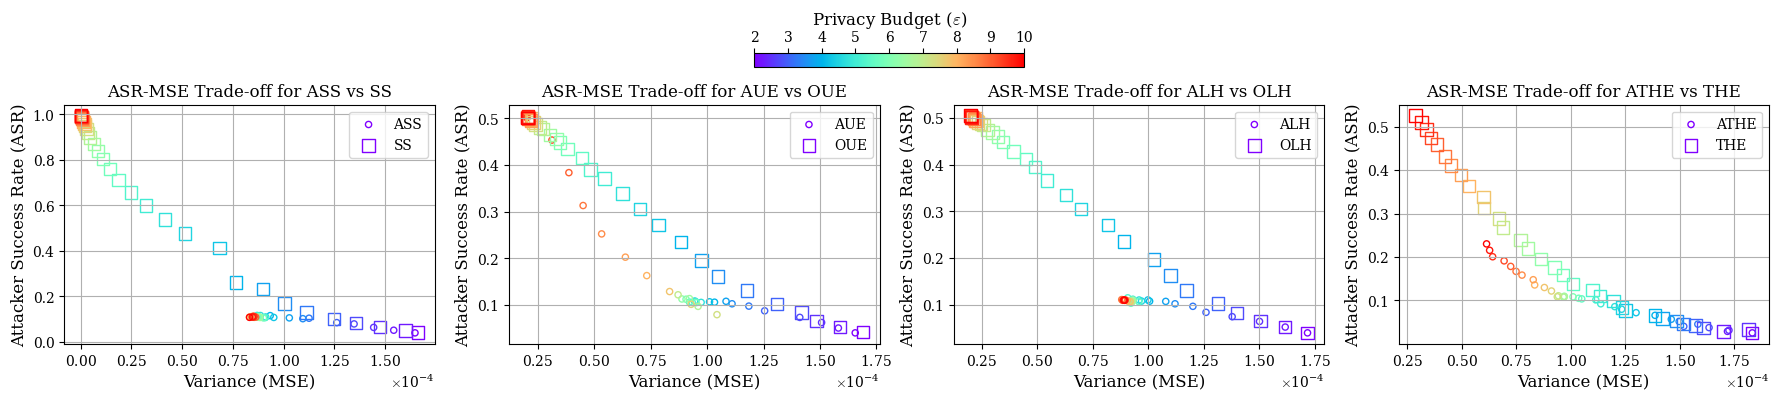

2025-01-06 13:45:17,969	INFO worker.py:1749 -- Started a local Ray instance.


SS ASS
OUE AUE
OLH ALH
THE ATHE


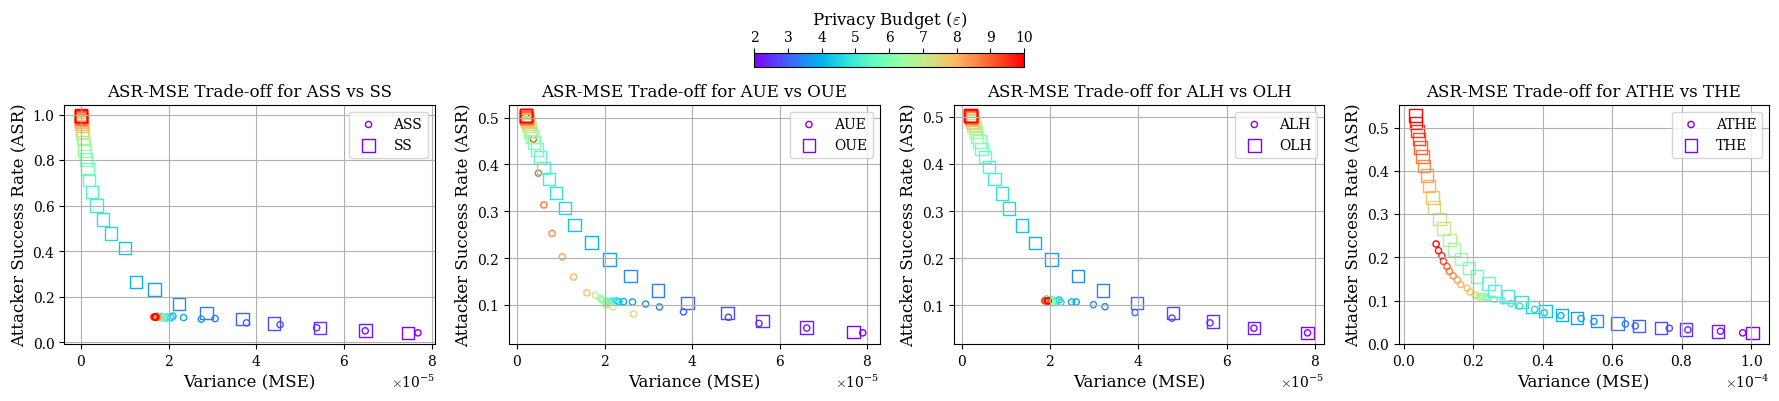

2025-01-06 13:54:50,018	INFO worker.py:1749 -- Started a local Ray instance.


SS ASS
OUE AUE
OLH ALH
THE ATHE


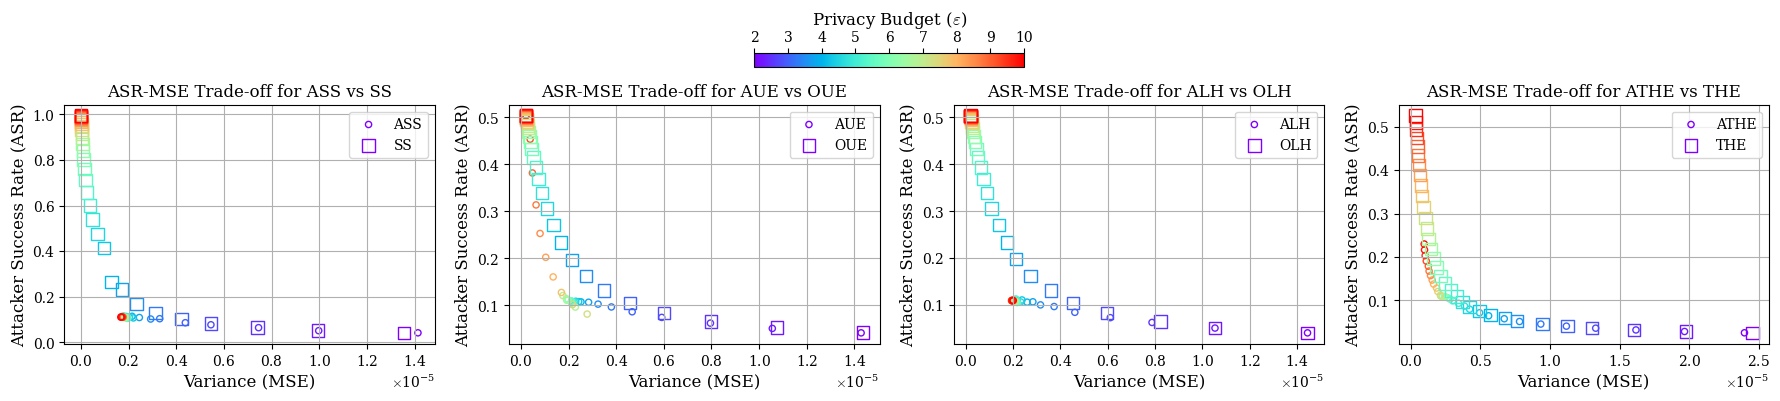

In [8]:
# Define protocols and parameters
protocols = [
    (SubsetSelection, AdaptiveSubsetSelection),
    (UnaryEncoding, AdaptiveUnaryEncoding),
    (LocalHashing, AdaptiveLocalHashing),
    (HistogramEncoding, AdaptiveThresholdingHistogramEncoding)
]
protocol_names = [
    ("SS", "ASS"),
    ("OUE", "AUE"),
    ("OLH", "ALH"),
    ("THE", "ATHE")
]

# Define a colormap and markers for the plots
colors = matplotlib.colormaps['rainbow'] 

markers_dict = {
    "SS": "s",
    "ASS": ".",
    "OUE": "s",
    "AUE": ".",
    "OLH": "s",
    "ALH": ".",
    "THE": "s",
    "ATHE": "."
}

# Function to compute empirical ASR and variance
@ray.remote
def compute_empirical_asr_variance(protocol_class, k, epsilon, data, seed):
    np.random.seed(seed)
    protocol = protocol_class(k, epsilon)
    noisy_reports = [protocol.obfuscate(val) for val in data]
    estimated_freq = protocol.estimate(noisy_reports)
    true_freq = np.bincount(data, minlength=k) / len(data)
    mse = np.mean((true_freq - estimated_freq) ** 2)
    correct_predictions = sum(protocol.attack(noisy_reports[i]) == data[i] for i in range(len(data)))
    asr = correct_predictions / len(data)
    return mse, asr

# Generate synthetic data
def generate_synthetic_data(n, k, seed=42):
    np.random.seed(seed)
    return np.random.randint(0, k, n)

nb_users = cfg.nb_users # Number of users
k = 100 # Fixed domain size
epsilon_values = np.arange(2, 10.1, 0.25)
nb_seeds = 100  # Number of seeds

for n in nb_users: 

    # Generate data
    data = generate_synthetic_data(n, k)

    # Initialize Ray for parallel processing
    ray.init(num_cpus=os.cpu_count(), ignore_reinit_error=True)

    # Plotting setup for a single-row teaser figure
    fig, axes = plt.subplots(1, 4, figsize=(22, 4.5))


    for idx, ((adaptive_protocol, non_adaptive_protocol), (adaptive_name, non_adaptive_name)) in enumerate(zip(protocols, protocol_names)):
        print(adaptive_name, non_adaptive_name)
        results = []
        for protocol_class, protocol_name in zip([non_adaptive_protocol, adaptive_protocol], [non_adaptive_name, adaptive_name]):
            tasks = []
            for epsilon in epsilon_values:
                for seed in range(nb_seeds):
                    tasks.append(compute_empirical_asr_variance.remote(protocol_class, k, epsilon, data, seed))
            
            task_results = ray.get(tasks)
            # Average results over seeds
            for i, epsilon in enumerate(epsilon_values):
                subset_results = task_results[i * nb_seeds:(i + 1) * nb_seeds]
                mse_values, asr_values = zip(*subset_results)
                results.append((np.mean(mse_values), np.mean(asr_values), protocol_name, epsilon))

        # Get the appropriate subplot axes
        ax = axes[idx]
        for variance, asr, protocol_name, epsilon in results:
            # Use colormap based on epsilon value (normalize by dividing by max epsilon value)
            color = colors((epsilon - min(epsilon_values)) / (max(epsilon_values) - min(epsilon_values)))
            ax.scatter(variance, asr, color=color, marker=markers_dict[protocol_name], s=80, facecolors='none', alpha=1, label=protocol_name if epsilon == epsilon_values[0] else "")

        # Customize the subplot
        ax.set_title(f'ASR-MSE Trade-off for {non_adaptive_name} vs {adaptive_name}', fontsize=12)
        ax.set_xlabel('Variance (MSE)', fontsize=12)
        ax.set_ylabel('Attacker Success Rate (ASR)', fontsize=12)
        ax.grid(True)
        
        # Set x-axis to scientific notation
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

        # Fix legend to display only one label per protocol
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        ax.legend(unique_handles, unique_labels, loc='best', fontsize=10)

    # Add a single colorbar for all subplots
    norm = plt.Normalize(vmin=min(epsilon_values), vmax=max(epsilon_values))
    sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.25, pad=0.06, location='top')
    cbar.set_label(r'Privacy Budget ($\varepsilon$)', fontsize=12)
    cbar.set_ticks(np.arange(epsilon_values.min(), epsilon_values.max() + 0.1, 1))
    cbar.ax.set_position([0.1, 0.725, 0.8, 0.03])  # Adjust the position to move it above the subplots)

    # Final layout adjustments and save
    plt.savefig('results/fig_asr_mse_pareto_frontier_empirical_n_' + str(n) + '.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    # Shutdown Ray
    ray.shutdown()


## Visualization of Synthetic data distribution for empirical experiments

Fixed k: 25


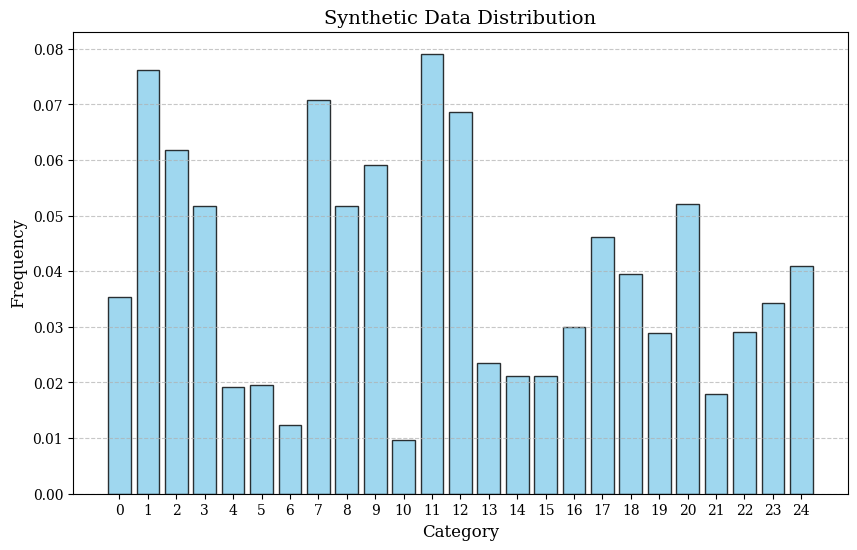

-----------------------------------
Fixed k: 100


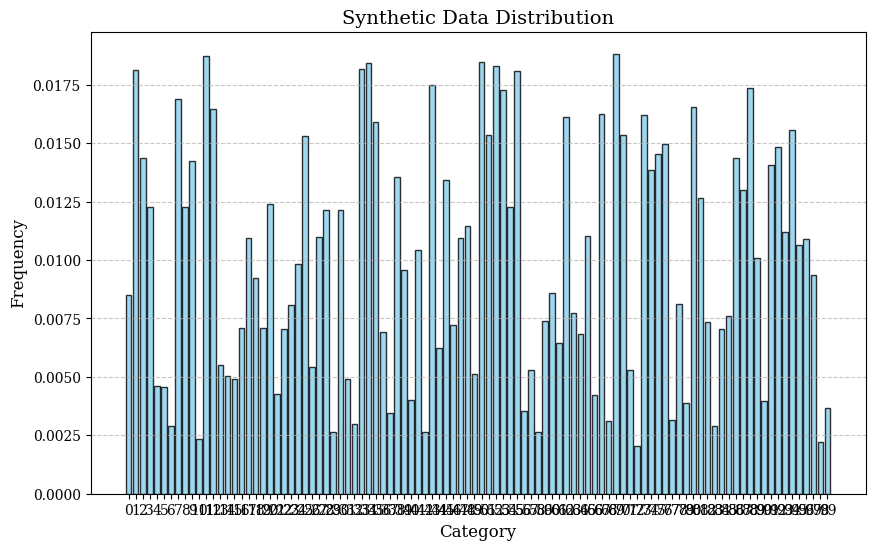

-----------------------------------


In [3]:
# Generate synthetic data
def generate_synthetic_data(n, k, alpha=None, alpha_randomness=1.0, seed=42):
    """Generate synthetic discrete data using Dirichlet distribution."""
    np.random.seed(seed)
    alpha = np.random.uniform(0.1, alpha_randomness, size=k) if alpha is None else np.asarray(alpha)
    probabilities = np.random.dirichlet(alpha, size=n)
    data = np.array([np.random.choice(k, p=prob) for prob in probabilities])
    return data

# Generate synthetic data
n = int(5e5)  # Number of users

for k in [25, 100]:
    print("Fixed k:", k)
    data = generate_synthetic_data(n, k)

    # Visualize the synthetic data distribution
    counts = np.bincount(data, minlength=k)
    freq = counts/n
    categories = np.arange(k)

    plt.figure(figsize=(10, 6))
    plt.bar(categories, freq, color='skyblue', alpha=0.8, edgecolor='black')
    plt.title("Synthetic Data Distribution", fontsize=14)
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(categories, labels=categories, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
    print("-----------------------------------")



## Optimizing the protocols: parameter vs objective function

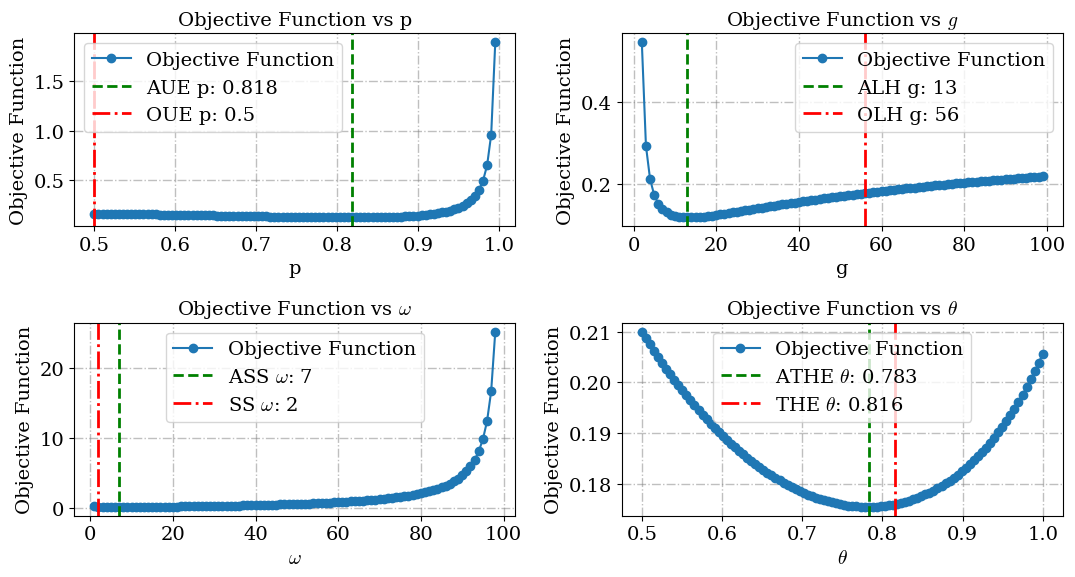

In [78]:
def compute_objective(protocol_class, k, epsilon, parameter_range, parameter_name, w_asr=0.5, w_mse=0.5):
    """
    Function to compute the objective function for a given protocol and parameter range.
    
    Parameters
    ----------
    protocol_class : class
        The adaptive protocol class to evaluate.
    k : int
        Attribute's domain size.
    epsilon : float
        Privacy budget for the LDP mechanism.
    parameter_name : str
        The name of the parameter being evaluated (e.g., 'p', 'g', 'omega', 'threshold').

    Returns
    -------
    list
        A list of objective function values.
    """
    protocol = protocol_class(k, epsilon, w_asr, w_mse)
    optimal_parameter = None

    # Dictionary to map parameter names to their corresponding attributes and methods
    param_map = {
        'p': ('p', lambda p: (p, p / (np.exp(epsilon) * (1 - p) + p))),
        'g': ('g', lambda g: (g,)),
        'Omega': ('omega', lambda omega: (omega,)),
        'threshold': ('threshold', lambda threshold: (threshold,))
    }

    if parameter_name not in param_map:
        raise ValueError("Invalid parameter name.")

    attr_name, param_func = param_map[parameter_name]
    optimal_parameter = getattr(protocol, attr_name)

    objective_values = []
    for param in parameter_range:
        params = param_func(param)
        obj = w_asr * protocol.get_asr(*params) + w_mse * protocol.get_variance(*params)
        objective_values.append(obj)

    return objective_values, optimal_parameter

# Parameters
k = 100  # Example domain size
epsilon = 4  # Example privacy budget

# Define parameter ranges for each adaptive protocol
p_range = AdaptiveUnaryEncoding(k, epsilon).get_parameter_range()
g_range = AdaptiveLocalHashing(k, epsilon).get_parameter_range()
omega_range = AdaptiveSubsetSelection(k, epsilon).get_parameter_range()
threshold_range = AdaptiveThresholdingHistogramEncoding(k, epsilon).get_parameter_range()

# Get the results from the parallel tasks
p_objective_values, optimal_p = compute_objective(AdaptiveUnaryEncoding, k, epsilon, p_range, 'p')
g_objective_values, optimal_g = compute_objective(AdaptiveLocalHashing, k, epsilon, g_range, 'g')
omega_objective_values, optimal_omega = compute_objective(AdaptiveSubsetSelection, k, epsilon, omega_range, 'Omega')
threshold_objective_values, optimal_threshold = compute_objective(AdaptiveThresholdingHistogramEncoding, k, epsilon, threshold_range, 'threshold')


params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'font.weight':'normal',
          }
matplotlib.rcParams.update(params)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(11, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Example original protocol parameter values (OUE, OLH, SS, THE)
original_p = UnaryEncoding(k, epsilon, optimal=True).p  # Parameter for OUE
original_g = LocalHashing(k, epsilon, optimal=True).g  # Parameter for OLH
original_omega = SubsetSelection(k, epsilon).omega  # Parameter for SS
original_threshold = HistogramEncoding(k, epsilon, thresholding=True).threshold  # Parameter for THE

# Plot for AUE (p vs objective function)
axes[0, 0].plot(p_range[:-1], p_objective_values[:-1], marker='o', label='Objective Function')
axes[0, 0].axvline(optimal_p, color='g', linewidth=2, linestyle='--', label='AUE p: ' + str(np.round(optimal_p, 3)))
axes[0, 0].axvline(original_p, color='r', linewidth=2, linestyle='-.', label='OUE p: ' + str(np.round(original_p, 3)))
axes[0, 0].set_title('Objective Function vs p')
axes[0, 0].set_xlabel('p')
axes[0, 0].set_ylabel('Objective Function')
axes[0, 0].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[0, 0].legend()

# Plot for ALH (g vs objective function)
axes[0, 1].plot(g_range, g_objective_values, marker='o', label='Objective Function')
axes[0, 1].axvline(optimal_g, color='g', linewidth=2, linestyle='--', label='ALH g: ' + str(optimal_g))
axes[0, 1].axvline(original_g, color='r', linewidth=2, linestyle='-.', label='OLH g: ' + str(original_g))
axes[0, 1].set_title(r'Objective Function vs $g$')
axes[0, 1].set_xlabel('g')
axes[0, 1].set_ylabel('Objective Function')
axes[0, 1].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[0, 1].legend()

# Plot for ASS (omega vs objective function)
axes[1, 0].plot(omega_range, omega_objective_values, marker='o', label='Objective Function')
axes[1, 0].axvline(optimal_omega, color='g', linewidth=2, linestyle='--', label=r'ASS $\omega$: ' +  str(optimal_omega))
axes[1, 0].axvline(original_omega, color='r', linewidth=2, linestyle='-.', label=r'SS $\omega$: ' +  str(original_omega))
axes[1, 0].set_title(r'Objective Function vs $\omega$')
axes[1, 0].set_xlabel(r'$\omega$')
axes[1, 0].set_ylabel('Objective Function')
axes[1, 0].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[1, 0].legend()

# Plot for ATHE (threshold vs objective function)
axes[1, 1].plot(threshold_range, threshold_objective_values, marker='o', label='Objective Function')
axes[1, 1].axvline(optimal_threshold, color='g', linewidth=2, linestyle='--', label=r'ATHE $\theta$: ' + str(np.round(optimal_threshold, 3)))
axes[1, 1].axvline(original_threshold, color='r', linewidth=2, linestyle='-.', label=r'THE $\theta$: ' + str(np.round(original_threshold, 3)))
axes[1, 1].set_title(r'Objective Function vs $\theta$')
axes[1, 1].set_xlabel(r'$\theta$')
axes[1, 1].set_ylabel('Objective Function')
axes[1, 1].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[1, 1].legend()

# Show the plot
plt.tight_layout()
plt.savefig('results/fig_opt_parameters_adaptive_protocols.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()


## Optimizing the protocols: impact of weights (asr and mse) on the objective function

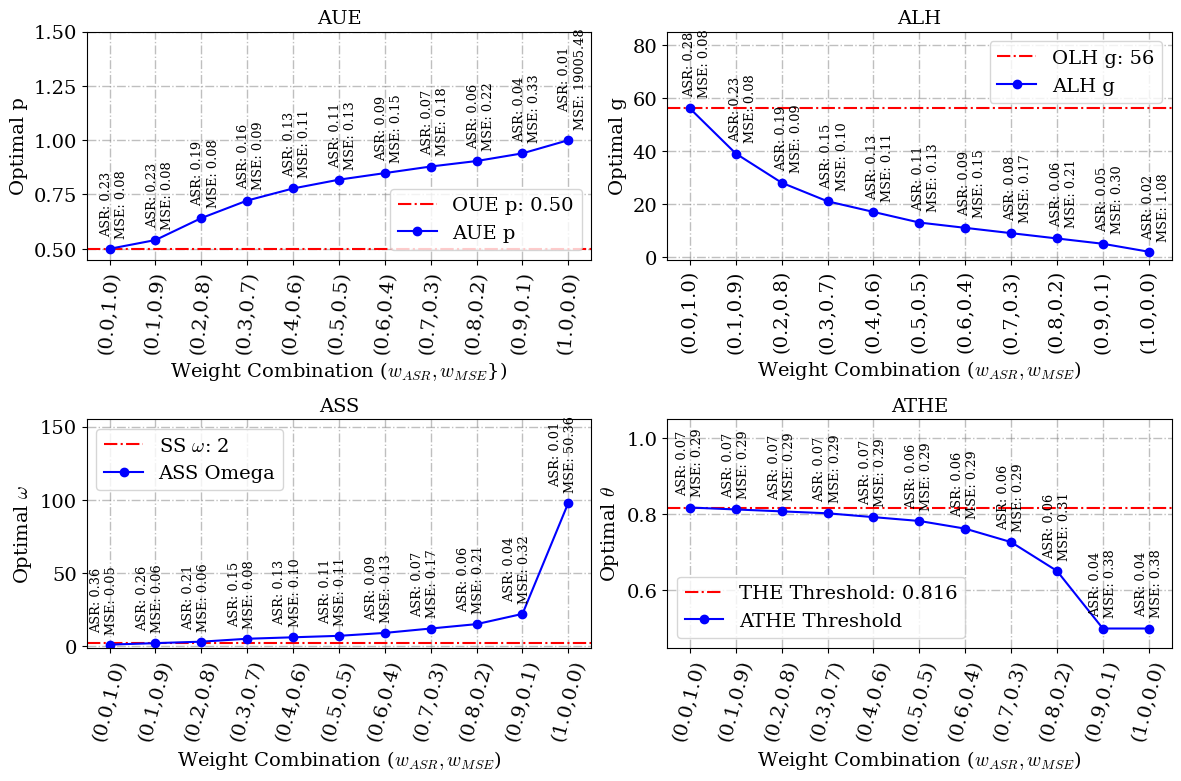

In [82]:
# Parameters
k = 100
epsilon = 4

# Weight combinations to evaluate
weight_pairs = [(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1.0, 0.0)]

# Compute optimal parameters for each weight combination
optimal_p_values = [AdaptiveUnaryEncoding(k, epsilon, w_asr, w_variance).p for (w_asr, w_variance) in weight_pairs]
optimal_g_values = [AdaptiveLocalHashing(k, epsilon, w_asr, w_variance).g for (w_asr, w_variance) in weight_pairs]
optimal_omega_values = [AdaptiveSubsetSelection(k, epsilon, w_asr, w_variance).omega for (w_asr, w_variance) in weight_pairs]
optimal_threshold_values = [AdaptiveThresholdingHistogramEncoding(k, epsilon, w_asr, w_variance).threshold for (w_asr, w_variance) in weight_pairs]

# Original protocol parameter values (OUE, OLH, SS, THE)
original_p = UnaryEncoding(k, epsilon, optimal=True).p  # Parameter for OUE
original_g = LocalHashing(k, epsilon, optimal=True).g  # Parameter for OLH
original_omega = SubsetSelection(k, epsilon).omega  # Parameter for SS
original_threshold = HistogramEncoding(k, epsilon, thresholding=True).threshold  # Parameter for THE

params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14',
          'font.size':'14',
          'legend.fontsize':'medium',
          'font.weight':'normal',
          }
matplotlib.rcParams.update(params)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
plt.subplots_adjust(wspace=0.15, hspace=0.7)

# Plot for AUE (p vs weight combination)
axes[0, 0].axhline(original_p, color='r', linestyle='-.', label=f'OUE p: {original_p:.2f}')
axes[0, 0].plot([f'({w_asr},{w_var})' for w_asr, w_var in weight_pairs], optimal_p_values, marker='o', label='AUE p', color='blue')
for (w_asr, w_var), p in zip(weight_pairs, optimal_p_values):
    aue = AdaptiveUnaryEncoding(k, epsilon, w_asr, w_var)
    asr = aue.get_asr()
    mse = aue.get_variance()
    axes[0, 0].annotate(f'ASR: {asr:.2f}\nMSE: {mse:.2f}', 
                        xy=(f'({w_asr},{w_var})', p), 
                        xytext=(3, 10),  
                        textcoords='offset points',
                        fontsize=9.25, rotation=90, ha='center')
axes[0, 0].set_title('AUE')
axes[0, 0].set_xlabel(r'Weight Combination ($w_{ASR}, w_{MSE}$)')
axes[0, 0].set_ylabel('Optimal p')
axes[0, 0].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[0, 0].legend(loc='lower right')
axes[0, 0].tick_params(axis='x', rotation=85)
axes[0, 0].set_ylim(0.45, 1.5)

# Plot for ALH (g vs weight combination)
axes[0, 1].axhline(original_g, color='r', linestyle='-.', label=f'OLH g: {int(original_g)}')
axes[0, 1].plot([f'({w_asr},{w_var})' for w_asr, w_var in weight_pairs], optimal_g_values, marker='o', label='ALH g', color='blue')
for (w_asr, w_var), g in zip(weight_pairs, optimal_g_values):
    alh = AdaptiveLocalHashing(k, epsilon, w_asr, w_var)
    asr = alh.get_asr()
    mse = alh.get_variance()
    axes[0, 1].annotate(f'ASR: {asr:.2f}\nMSE: {mse:.2f}', 
                        xy=(f'({w_asr},{w_var})', g), 
                        xytext=(5, 10),  
                        textcoords='offset points',
                        fontsize=9.25, rotation=90, ha='center')
axes[0, 1].set_title('ALH')
axes[0, 1].set_xlabel(r'Weight Combination ($w_{ASR}, w_{MSE}$)')
axes[0, 1].set_ylabel('Optimal g')
axes[0, 1].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[0, 1].legend(loc='upper right')
axes[0, 1].tick_params(axis='x', rotation=90)
axes[0, 1].set_ylim(-1, 85)

# Plot for ASS (omega vs weight combination)
axes[1, 0].axhline(original_omega, color='r', linestyle='-.', label=f'SS $\omega$: {int(original_omega)}')
axes[1, 0].plot([f'({w_asr},{w_var})' for w_asr, w_var in weight_pairs], optimal_omega_values, marker='o', label='ASS Omega', color='blue')
for (w_asr, w_var), omega in zip(weight_pairs, optimal_omega_values):
    ass = AdaptiveSubsetSelection(k, epsilon, w_asr, w_var)
    asr = ass.get_asr()
    mse = ass.get_variance()
    axes[1, 0].annotate(f'ASR: {asr:.2f}\nMSE: {mse:.2f}', 
                        xy=(f'({w_asr},{w_var})', omega), 
                        xytext=(-4, 10),  
                        textcoords='offset points',
                        fontsize=9.25, rotation=90, ha='center')
axes[1, 0].set_title('ASS')
axes[1, 0].set_xlabel(r'Weight Combination ($w_{ASR}, w_{MSE}$)')
axes[1, 0].set_ylabel(r'Optimal $\omega$')
axes[1, 0].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[1, 0].legend(loc='upper left')
axes[1, 0].tick_params(axis='x', rotation=75)
axes[1, 0].set_ylim(-1, 155)

# Plot for ATHE (threshold vs weight combination)
axes[1, 1].axhline(original_threshold, color='r', linestyle='-.', label=f'THE Threshold: {original_threshold:.3f}')
axes[1, 1].plot([f'({w_asr},{w_var})' for w_asr, w_var in weight_pairs], optimal_threshold_values, marker='o', label='ATHE Threshold', color='blue')
for (w_asr, w_var), threshold in zip(weight_pairs, optimal_threshold_values):
    athe = AdaptiveThresholdingHistogramEncoding(k, epsilon, w_asr, w_var)
    asr = athe.get_asr()
    mse = athe.get_variance()
    axes[1, 1].annotate(f'ASR: {asr:.2f}\nMSE: {mse:.2f}', 
                        xy=(f'({w_asr},{w_var})', threshold), 
                        xytext=(0, 10),  
                        textcoords='offset points',
                        fontsize=9.25, rotation=90, ha='center')
axes[1, 1].set_title('ATHE')
axes[1, 1].set_xlabel(r'Weight Combination ($w_{ASR}, w_{MSE}$)')
axes[1, 1].set_ylabel(r'Optimal $\theta$')
axes[1, 1].grid(color='grey', linestyle='dashdot', linewidth=1, alpha=0.5)
axes[1, 1].legend(loc = 'lower left')
axes[1, 1].tick_params(axis='x', rotation=75)
axes[1, 1].set_ylim(0.45, 1.05)

# Show the plot
plt.savefig('results/fig_weights_impact.pdf', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()
